In [2]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.distance import geodesic
from geopy.point import Point
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys
import cv2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
drive.mount( '/content/drive', force_remount=True )
PATH = "/content/drive/MyDrive/for thesis" #change to the path to your folder with datasets and images
os.chdir(PATH)

Mounted at /content/drive


In [ ]:
# Load the coordinates of all the images of the City Street View Dataset
#dataset available here: https://www.kaggle.com/datasets/stelath/city-street-view-dataset
gsv = pd.read_csv('picture_coords.csv',header=None)
print(gsv.head())

           0           1
0  40.864413  -73.893292
1  38.884714  -76.927431
2  42.367025  -83.115961
3  37.798462 -122.423526
4  41.699542  -87.690806


## Exploring police data

A popular dataset about San Francisco that contains information about its residents is the San Francisco Police Department (SFPD) Incident Report dataset. It includes information such as the time, location, and category of incidents that have been reported to the SFPD. The location data is given in the form of longitude and latitude, which can be mapped to the specific block, district, or street. The dataset is available for download on the San Francisco OpenData website: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783 

Let's load it and see what's in there.

In [ ]:
# Read the .csv file
police = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
print(police.columns)
pd.set_option('display.max_columns', None)
display(police)

Index(['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID',
       'Incident Number', 'CAD Number', 'Report Type Code',
       'Report Type Description', 'Filed Online', 'Incident Code',
       'Incident Category', 'Incident Subcategory', 'Incident Description',
       'Resolution', 'Intersection', 'CNN', 'Police District',
       'Analysis Neighborhood', 'Supervisor District', 'Latitude', 'Longitude',
       'Point', 'Neighborhoods', 'ESNCAG - Boundary File',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'Civic Center Harm Reduction Project Boundary',
       'HSOC Zones as of 2018-06-05', 'Invest In Neighborhoods (IIN) Areas',
       'Current Supervisor Districts', 'Current Police Districts'],
      dtype='object')


Incident Datetime Incident Date Incident Time  Incident Year  \
0       2021/07/25 12:00:00 AM    2021/07/25         00:00           2021   
1       2022/06/28 11:58:00 PM    2022/06/28         23:58           2022   
2       2022/03/11 10:30:00 AM    2022/03/11         10:30           2022   
3       2021/05/15 05:47:00 PM    2021/05/15         17:47           2021   
4       2022/06/28 05:22:00 PM    2022/06/28         17:22           2022   
...                        ...           ...           ...            ...   
693196  2023/02/09 04:48:00 PM    2023/02/09         16:48           2023   
693197  2023/02/01 08:00:00 AM    2023/02/01         08:00           2023   
693198  2023/02/09 08:00:00 AM    2023/02/09         08:00           2023   
693199  2023/02/07 11:24:00 PM    2023/02/07         23:24           2023   
693200  2023/02/09 10:00:00 AM    2023/02/09         10:00           2023   

       Incident Day of Week         Report Datetime        Row ID  \
0                    Sunday  2021/07/25 01:41:00 PM  105718906372   
1                   Tuesday  2022/06/28 11:58:00 PM  116554371012   
2                    Friday  2022/03/11 08:03:00 PM  113048071000   
3                  Saturday  2021/05/15 05:47:00 PM  103051807043   
4                   Tuesday  2022/06/28 05:22:00 PM  116535107041   
...                     ...                     ...           ...   
693196             Thursday  2023/02/09 04:48:00 PM  124292363010   
693197            Wednesday  2023/02/09 04:20:00 PM  124289815410   
693198             Thursday  2023/02/09 12:15:00 PM  124285615201   
693199              Tuesday  2023/02/07 11:24:00 PM  124244375025   
693200             Thursday  2023/02/09 04:43:00 PM  124293672000   

        Incident ID  Incident Number   CAD Number Report Type Code  \
0           1057189        216105573          NaN               II   
1           1165543        220264913          NaN               VS   
2           1130480        226040232          NaN               II   
3           1030518        210183345          NaN               VS   
4           1165351        220361741          NaN               VS   
...             ...              ...          ...              ...   
693196      1242923        230097538  230402481.0               II   
693197      1242898        230097334  230402375.0               II   
693198      1242856        230096825  230401513.0               II   
693199      1242443        230093332  230383543.0               II   
693200      1242936        230097447  230402466.0               II   

       Report Type Description Filed Online  Incident Code  \
0             Coplogic Initial         True           6372   
1           Vehicle Supplement          NaN          71012   
2             Coplogic Initial         True          71000   
3           Vehicle Supplement          NaN           7043   
4           Vehicle Supplement          NaN           7041   
...                        ...          ...            ...   
693196                 Initial          NaN          63010   
693197                 Initial          NaN          15410   
693198                 Initial          NaN          15201   
693199                 Initial          NaN          75025   
693200                 Initial          NaN          72000   

                               Incident Category   Incident Subcategory  \
0                                  Larceny Theft  Larceny Theft - Other   
1                                 Other Offenses         Other Offenses   
2                                  Lost Property          Lost Property   
3                              Recovered Vehicle      Recovered Vehicle   
4                              Recovered Vehicle      Recovered Vehicle   
...                                          ...                    ...   
693196                                   Warrant                  Other   
693197                                       NaN                    NaN  

In [ ]:
size = len(police)
print("The number of records in the dataset:",size)

The number of records in the dataset: 693201


In order to decide what data we could investigate with SVI, we have to see what types of records there are, how many types, how frequent the types are, how frequently do the records miss latitude and longitude coordinates. Of the records that have sufficient frequency, that don't miss too many lat-lon coordinates and of which the records with missing coordinates are not specific in any obvious way we pick the type of crime that might most likely be related to the street environment.

In [ ]:
print("How many unique incident descriptions:")
pd.unique(police['Incident Description']).size

How many unique incident descriptions:


838

In [ ]:
print("What are the incident subcategories:")
pd.unique(police['Incident Subcategory'])

What are the incident subcategories:


array(['Larceny Theft - Other', 'Other Offenses', 'Lost Property',
       'Recovered Vehicle', 'Vandalism', 'Larceny - From Vehicle',
       'Burglary - Hot Prowl', 'Missing Person', 'Fraud',
       'Traffic Violation Arrest', 'Trespass', 'Drug Violation',
       'Motor Vehicle Theft', 'Missing Adult', 'Burglary - Residential',
       'Other', 'Robbery - Commercial', 'Warrant', 'Theft From Vehicle',
       'Arson', 'Stolen Property', 'Aggravated Assault',
       'Weapons Offense', 'Drunkenness', 'Suspicious Occ', 'Non-Criminal',
       'Larceny Theft - Shoplifting', 'Courtesy Report', 'Case Closure',
       'Burglary - Commercial', 'Simple Assault',
       'Larceny Theft - From Building', 'Fire Report',
       'Miscellaneous Investigation', nan, 'Burglary - Other',
       'Disorderly Conduct', 'Larceny Theft - Bicycle',
       'Forgery And Counterfeiting', 'Intimidation', 'Robbery - Other',
       'Sex Offense', 'Motor Vehicle Theft (Attempted)',
       'Robbery - Street', 'Extortion-B

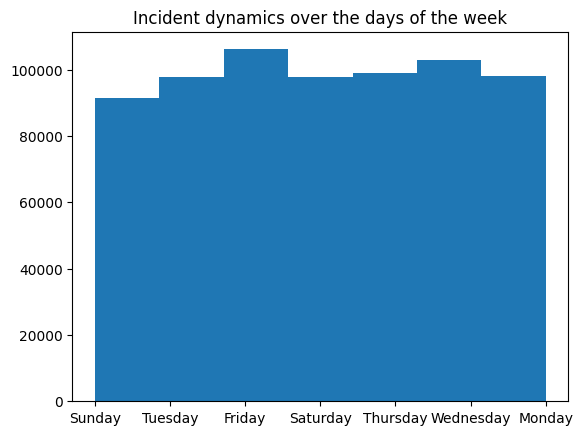

In [ ]:
plt.hist(police['Incident Day of Week'],bins=7)
plt.title("Incident dynamics over the days of the week")
plt.show()

Let's display the top incident descriptions with their counts and frequencies.

In [ ]:
print("The most oftenly occurring incident descriptions:")
descr = police.groupby(['Incident Description'])['Incident Description'].count().reset_index(name='count').sort_values(['count'],ascending=False)
descr['freq, %'] = round(descr['count']*100/size,2)
descr.head(10)

The most oftenly occurring incident descriptions:


Incident Description  count  freq, %
706          Theft, From Locked Vehicle, >$950  87810    12.67
417  Malicious Mischief, Vandalism to Property  23070     3.33
84                                     Battery  20409     2.94
402                              Lost Property  20240     2.92
727            Theft, Other Property, $50-$200  19515     2.82
791                   Vehicle, Recovered, Auto  19506     2.81
802                      Vehicle, Stolen, Auto  18873     2.72
729               Theft, Other Property, >$950  16478     2.38
429                    Mental Health Detention  15374     2.22
716        Theft, From Unlocked Vehicle, >$950  13068     1.89

Well, descriptions don't seem to be a good categorisation. What's "Battery" as a description of an incident, for example? Let's look at the higher granularity of descriptions - the categories of the incidents.

In [ ]:
print("The most frequent incidents:")
cat = police.groupby(['Incident Category'])['Incident Category'].count().reset_index(name='count').sort_values(['count'],ascending=False)
cat['freq, %'] = round(cat['count']*100/size,2)
cat.head(10)

The most frequent incidents:


Incident Category   count  freq, %
18        Larceny Theft  211377    30.49
29  Other Miscellaneous   48443     6.99
21   Malicious Mischief   46937     6.77
1               Assault   42139     6.08
26         Non-Criminal   41405     5.97
2              Burglary   39063     5.64
24  Motor Vehicle Theft   35240     5.08
33    Recovered Vehicle   26870     3.88
12                Fraud   21929     3.16
20        Lost Property   20240     2.92

Okay, this is more concrete, though the second place is occupied by "other". What are the crimes that occur the least, by the way?

In [ ]:
print("The least frequent incidents:")
cat.tail(10)

The least frequent incidents:


Incident Category  count  freq, %
32                                          Rape    166     0.02
15    Human Trafficking (A), Commercial Sex Acts    129     0.02
14                                      Homicide    103     0.01
38                                    Suspicious     99     0.01
19                                   Liquor Laws     75     0.01
25                          Motor Vehicle Theft?     74     0.01
13                                      Gambling     32     0.00
17        Human Trafficking, Commercial Sex Acts     21     0.00
47                               Weapons Offence     20     0.00
16  Human Trafficking (B), Involuntary Servitude      1     0.00

If we already started looking at different levels of granularity, let's also look at the subcategories in order to not miss some interesting subcategory that would be interesting to investigate with the analysis of the environment.

In [ ]:
print("The most frequent subcategories:")
subcat = police.groupby(['Incident Subcategory'])['Incident Subcategory'].count().reset_index(name='count').sort_values(['count'],ascending=False)
subcat['freq, %'] = round(subcat['count']*100/size,2)
subcat.head(10)

The most frequent subcategories:


Incident Subcategory   count  freq, %
27  Larceny - From Vehicle  120018    17.31
44                   Other   86428    12.47
30   Larceny Theft - Other   48699     7.03
67               Vandalism   46611     6.72
41     Motor Vehicle Theft   34719     5.01
49       Recovered Vehicle   26870     3.88
56          Simple Assault   26177     3.78
43            Non-Criminal   23777     3.43
18                   Fraud   22945     3.31
36           Lost Property   20240     2.92

In [ ]:
print("The least frequent subcategories:")
subcat.tail(10)

The least frequent subcategories:


Incident Subcategory  count  freq, %
37                              Manslaughter     57     0.01
48                          Rape - Attempted     54     0.01
3                                 Bad Checks     46     0.01
20                                  Homicide     45     0.01
19                                  Gambling     32     0.00
53                     Robbery - Residential     25     0.00
1                                     Arrest      6     0.00
4                                    Bribery      5     0.00
21                      Homicide - Excusable      1     0.00
23  Human Trafficking, Involuntary Servitude      1     0.00

Larceny from vehicle looks like concrete enough. At the same time it has enough data points. And it seems to be a crime that might be related to the street environment, as it only happens at the street.

#### How many latitudes and longitudes are missing

In [ ]:
print("ratio of records with missing latitude value:",police['Latitude'].isnull().sum()/size)
print("ratio of records with missing longitude value:",police['Longitude'].isnull().sum()/size)

ratio of records with missing latitude value: 0.053074072310917035
ratio of records with missing longitude value: 0.053074072310917035


Okay, seems like latitude and longitude are missing for the same records, because the ratio is so exactly the same. 

Are these records any specific though? We look into count of values of Incident Subcategory where Latitude (as well as Longitude, as we suspect) is missing.

It occurs with 58 categories out of 73


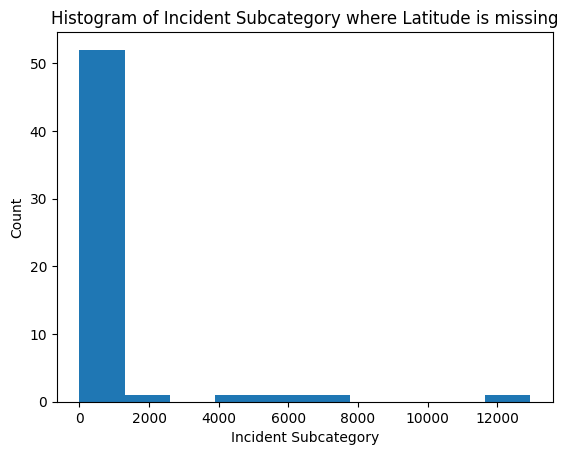

In [ ]:
no_lat = police['Incident Subcategory'][police['Latitude'].isnull()]
print("It occurs with {} categories out of {}".format(pd.unique(no_lat).size,pd.unique(police['Incident Subcategory']).size))

no_lat_counts = no_lat.value_counts()
plt.hist(no_lat_counts)

plt.xlabel('Incident Subcategory')
plt.ylabel('Count')
plt.title('Histogram of Incident Subcategory where Latitude is missing')

plt.show()

Given a small number of missing latitudes and longitudes and that almost every category has them we don't investigate further. We do not aim at traditional statistical tests in this project, and for training an neural net the amount of data we have for Larceny - From Vehicle should be enough to ensure diversity of the target even if some values are missing and some records will therefore be discarded.

In [ ]:
print("Creating a dataset with geographical coordinates of the most represented incident subcategory.")
larceny_fr_veh = police[:][police['Incident Subcategory'] == 'Larceny - From Vehicle']
larceny_fr_veh = larceny_fr_veh[:][larceny_fr_veh['Latitude'].isnull() == False]
larceny_fr_veh = larceny_fr_veh[:][larceny_fr_veh['Longitude'].isnull() == False]
larceny_fr_veh = larceny_fr_veh[['Latitude','Longitude']].copy()
print("Larceny - From Vehicle:")
display(larceny_fr_veh)


Creating a dataset with geographical coordinates of the most represented incident subcategory.
Larceny - From Vehicle:


Latitude   Longitude
45      37.805497 -122.422007
58      37.784007 -122.404865
60      37.807073 -122.417261
62      37.807163 -122.408897
71      37.778021 -122.421521
...           ...         ...
693139  37.789783 -122.404208
693150  37.786085 -122.433272
693163  37.749187 -122.506219
693169  37.722726 -122.441431
693178  37.764037 -122.466311

[107065 rows x 2 columns]

## Connecting GSVI and crime geographical coordinates

We need the data in array form, so we create arrays.

In [ ]:
l_f_v_a = larceny_fr_veh.to_numpy()
gsv_a = gsv.to_numpy()

We only need SVI from San Francisco as that's the only source of crime data we have. Here we sample all the SVI coordinates that lay within San Francisco area. 

In [ ]:
#make a subset of the images locations for images from San Francisco
san_fran_ind = []
for i in range(len(gsv_a)):
    if geodesic(gsv_a[i],[37.755101, -122.446700]).km <= 30: #some spot in the middle for SF, 30 km is much more than needed
        san_fran_ind.append(i)
print(len(san_fran_ind))

san_fran = gsv_a[san_fran_ind]
print(san_fran.shape)

9625
(9625, 2)


In [ ]:
print(l_f_v_a.shape) #let's see what the size of the selected crimes locations is

(107065, 2)


To visually explore the relationship beetween the data out of curiosity, we make a map here. The locations for which SVI are available in the dataset are marked in blue, and the locations for which larceny from vehicle was reported are marked in red.

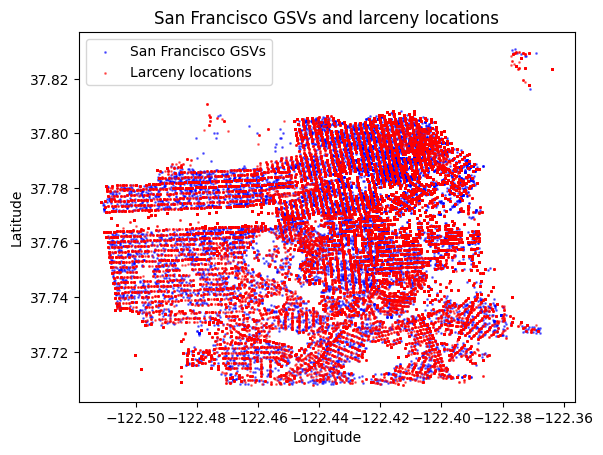

In [ ]:
# Scatter plot for San Francisco GSVs (blue dots)
plt.scatter(san_fran[:, 1], san_fran[:, 0], color='blue', s=1, alpha = 0.5, label='San Francisco GSVs')

# Scatter plot for Larceny locations (red dots)
plt.scatter(l_f_v_a[:, 1], l_f_v_a[:, 0], color='red', s=1, alpha = 0.5, label='Larceny locations')

# Set axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set plot title
plt.title('San Francisco GSVs and larceny locations')

# Add legend
plt.legend()

# Display the plot
plt.show()

Well, just with a naked eye it looks like crime data is even more regular than the SVI. But there are some districts where red is more dense. Let's hope it shows up in the network training results.

Let's check if some of the coordinates are in both datasets, so if there are crimes that happened exactly at the location for which we have SVI available. 

In [ ]:
c = 0
for row in l_f_v_a:
    if row in gsv_a:
        c+=1
print(c)

0


So, none of the exact locations of crime are on the photo. Then we have to define some measure of viscinity to look into the pictures in the close viscinity from the crime scene. 

We now find the locations in two datasets that are close to each other. After trying different radius, from 20 to 50 meters, we chose 35 meters, because then it still makes more or less sense (the street probably looked the same 35 meters around the crime scene, at least some features should be there), but also it still produces enough labels in the minority class to train the model.

In [ ]:
labels = np.zeros(san_fran.shape[0])
for i in range(san_fran.shape[0]):
    for j in range(l_f_v_a.shape[0]):
        if geodesic(san_fran[i],l_f_v_a[j]).km <= 0.035:
            labels[i] = 1

np.savez_compressed('labels.npz', labels=labels)


# Loading images
Because my images are not ImageNet, they are stored all in one folder, I need to create a custom dataset object in order to load them according to the labels stored in a separate array.

In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

We also create a folder with only the San Francisco images. I ran the code below on my local PC and then upload the resulting folder to the Google Drive to have access to it from here. One could try to use it this way, or to run it on Colab, but I don't know if that would work. Anyways, create the "Only_San_Fran" directory first. 

In [ ]:
import shutil

files_to_move = [f'street_view_{index}.jpg' for index in san_fran_ind]
print(files_to_move)

src_dir = './'
dst_dir = src_dir+'Only_San_Fran/'

for file in files_to_move:
    shutil.copy(src_dir+file, dst_dir+file)

In [6]:
#produce the image paths, import the labels
image_paths = os.listdir('./Only_San_Fran')
labels_init = np.load('labels_35_m.npz')['labels']
image_paths.sort(key=lambda x: int(x[12:-4]))
print(image_paths[:20])
print(labels_init[:20])
labels_init = labels_init.astype(int)
print(labels_init[:20])

os.chdir("./Only_San_Fran")

['street_view_3.jpg', 'street_view_7.jpg', 'street_view_11.jpg', 'street_view_13.jpg', 'street_view_16.jpg', 'street_view_27.jpg', 'street_view_31.jpg', 'street_view_37.jpg', 'street_view_38.jpg', 'street_view_41.jpg', 'street_view_43.jpg', 'street_view_62.jpg', 'street_view_63.jpg', 'street_view_64.jpg', 'street_view_66.jpg', 'street_view_76.jpg', 'street_view_78.jpg', 'street_view_80.jpg', 'street_view_82.jpg', 'street_view_84.jpg']
[False False  True False False False  True  True  True  True False False
  True False False False False  True  True False]
[0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0]


In [15]:
# Calculate the class imbalance ratio
positive_count = np.sum(labels_init)
negative_count = len(labels_init) - positive_count
imbalance_ratio = negative_count / positive_count
print(positive_count, negative_count, imbalance_ratio)

2384 7241 3.0373322147651005


In [7]:
#define transforms, create your dataset using the defined paths and create the data loader

# Define the data transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

custom_dataset = CustomDataset(image_paths, labels_init, transform=train_transforms)


Split the data:

In [ ]:
# Determine the size of the train/validation split
train_size = int(len(custom_dataset) * 0.7) #we used 0.25 for hyperparameter selection here
val_size = int(len(custom_dataset) * 0.15)
test_size = len(custom_dataset) - train_size - val_size

# Randomly split the dataset into train and validation sets
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

You always need to install timm while on Colab when you run this notebook.

In [8]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Fine-tune pre-trained ViT: model selection

We use DeiT Tiny here because the visualization pipeline that we adapt from Gildenblat, J. (2020). Exploring Explainability for Vision Transformers. https://jacobgil.github.io/deeplearning/vision-transformer-explainability is developed based on DeiT Tiny.

Now we will perform model selection. In order to be able to test a number of hyperparameters without re-defining model in the code every time, we define a function for building and training a model and displaying some metrics on it. 

In [ ]:
def train_custom_model(model_name, unfreeze_layers, optimizer_fn, lr):

  #load the pre-trained model:
  model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=True)

  # Get the number of transformer layers
  num_transformer_layers = len(model.blocks)

  # Freeze all layers except the specified number of unfrozen layers
  for i in range(num_transformer_layers - unfreeze_layers):
      for param in model.blocks[i].parameters():
          param.requires_grad = False

  #adjust the head
  num_classes = 1
  in_features = model.head.in_features

  model.head = nn.Sequential(
      nn.BatchNorm1d(num_features=in_features), #include batch normalization for efficiency
      nn.ReLU(),
      nn.Linear(in_features, num_classes)
  )

  model = model.to(device)

  #create a weight tensor for the positive (minor) class
  pos_weight = torch.FloatTensor([imbalance_ratio]).to(device)

  #define the loss function
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device) #this one includes Sigmoid 
  #it's advised by Torch to use this instead of nn.Sigmoid in the net and BCELoss here. More stable.

  #define your optimizer
  optimizer = optimizer_fn(model.parameters(), lr=lr)

  #define the learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

  num_epochs = 15
  for epoch in range(num_epochs):
      # Training
      train_loss = 0.0
      train_correct = 0
      train_total = 0
      train_f1_total = 0
      model.train()
      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels.float())
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          outputs = torch.sigmoid(outputs)  # apply sigmoid to get probabilities
          preds = (outputs.squeeze() >= 0.5).float()  
          train_correct += torch.sum(preds == labels.data)
          train_total += labels.size(0)
          train_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='macro') * labels.size(0)

      train_loss = train_loss / len(train_loader.dataset)
      train_acc = train_correct.item() / train_total
      train_f1 = train_f1_total / train_total

      # Validation
      val_loss = 0.0
      val_correct = 0
      val_total = 0
      val_f1_total = 0
      model.eval()
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs.squeeze(), labels.float())
              val_loss += loss.item()
              outputs = torch.sigmoid(outputs)
              preds = (outputs.squeeze() >= 0.5).float()
              val_correct += torch.sum(preds == labels.data)  
              val_total += labels.size(0)
              val_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='macro') * labels.size(0)

      val_loss = val_loss / len(val_loader.dataset)
      val_acc = val_correct.item() / val_total
      val_f1 = val_f1_total / val_total

      scheduler.step(val_loss)

      print(f'Epoch [{epoch+1}/{num_epochs}],\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, \
      Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')


Now we can do hyperparameter exploration with our small training sample and our custom function. We will later train the most promising model with more data and for more epochs.

In [ ]:
m_names = ['deit_tiny_patch16_224', 'deit_small_patch16_224']
to_unfreeze = [0,1,2,5]
lr_s = [0.001, 0.01]
optimizers = [optim.Adam, optim.SGD, optim.Adagrad]

for m_n in m_names:
  for to_unfr in to_unfreeze:
    for lr in lr_s:
      for opt in optimizers:
        print(m_n, to_unfr, lr, str(opt), end='\n\n')
        train_custom_model(m_n, to_unfr, opt, lr)
        print('')

deit_tiny_patch16_224 0 0.001 <class 'torch.optim.adam.Adam'>



Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth
100%|██████████| 21.9M/21.9M [00:00<00:00, 109MB/s]


Epoch [1/15],
Train Loss: 0.0332, Train Acc: 0.5179,       Train F1: 0.5427, Val Loss: 0.0335, Val Acc: 0.5191, Val F1: 0.5524
Epoch [2/15],
Train Loss: 0.0332, Train Acc: 0.5432,       Train F1: 0.5678, Val Loss: 0.0336, Val Acc: 0.4816, Val F1: 0.5125
Epoch [3/15],
Train Loss: 0.0331, Train Acc: 0.5374,       Train F1: 0.5668, Val Loss: 0.0334, Val Acc: 0.6168, Val F1: 0.6323
Epoch [4/15],
Train Loss: 0.0330, Train Acc: 0.5183,       Train F1: 0.5494, Val Loss: 0.0334, Val Acc: 0.7034, Val F1: 0.6754
Epoch [5/15],
Train Loss: 0.0330, Train Acc: 0.5528,       Train F1: 0.5819, Val Loss: 0.0334, Val Acc: 0.4893, Val F1: 0.5220
Epoch [6/15],
Train Loss: 0.0331, Train Acc: 0.5470,       Train F1: 0.5782, Val Loss: 0.0329, Val Acc: 0.5336, Val F1: 0.5675
Epoch [7/15],
Train Loss: 0.0330, Train Acc: 0.5544,       Train F1: 0.5828, Val Loss: 0.0328, Val Acc: 0.5807, Val F1: 0.6085
Epoch [8/15],
Train Loss: 0.0326, Train Acc: 0.5411,       Train F1: 0.5713, Val Loss: 0.0330, Val Acc: 0.4692,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0336, Train Acc: 0.4983,       Train F1: 0.5337, Val Loss: 0.0338, Val Acc: 0.4955, Val F1: 0.5320
Epoch [2/15],
Train Loss: 0.0336, Train Acc: 0.5042,       Train F1: 0.5394, Val Loss: 0.0339, Val Acc: 0.5107, Val F1: 0.5455
Epoch [3/15],
Train Loss: 0.0335, Train Acc: 0.5025,       Train F1: 0.5374, Val Loss: 0.0337, Val Acc: 0.5080, Val F1: 0.5407
Epoch [4/15],
Train Loss: 0.0332, Train Acc: 0.5108,       Train F1: 0.5462, Val Loss: 0.0334, Val Acc: 0.5412, Val F1: 0.5731
Epoch [5/15],
Train Loss: 0.0331, Train Acc: 0.5054,       Train F1: 0.5402, Val Loss: 0.0335, Val Acc: 0.5149, Val F1: 0.5492
Epoch [6/15],
Train Loss: 0.0327, Train Acc: 0.5353,       Train F1: 0.5708, Val Loss: 0.0331, Val Acc: 0.5329, Val F1: 0.5662
Epoch [7/15],
Train Loss: 0.0329, Train Acc: 0.5291,       Train F1: 0.5646, Val Loss: 0.0329, Val Acc: 0.5537, Val F1: 0.5852
Epoch [8/15],
Train Loss: 0.0332, Train Acc: 0.5353,       Train F1: 0.5705, Val Loss: 0.0331, Val Acc: 0.5315,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0336, Train Acc: 0.5357,       Train F1: 0.5674, Val Loss: 0.0337, Val Acc: 0.5350, Val F1: 0.5669
Epoch [2/15],
Train Loss: 0.0332, Train Acc: 0.5258,       Train F1: 0.5606, Val Loss: 0.0334, Val Acc: 0.5080, Val F1: 0.5407
Epoch [3/15],
Train Loss: 0.0329, Train Acc: 0.5278,       Train F1: 0.5627, Val Loss: 0.0329, Val Acc: 0.5482, Val F1: 0.5795
Epoch [4/15],
Train Loss: 0.0326, Train Acc: 0.5357,       Train F1: 0.5691, Val Loss: 0.0334, Val Acc: 0.5163, Val F1: 0.5499
Epoch [5/15],
Train Loss: 0.0328, Train Acc: 0.5495,       Train F1: 0.5810, Val Loss: 0.0331, Val Acc: 0.5301, Val F1: 0.5628
Epoch [6/15],
Train Loss: 0.0327, Train Acc: 0.5507,       Train F1: 0.5846, Val Loss: 0.0329, Val Acc: 0.5405, Val F1: 0.5736
Epoch [7/15],
Train Loss: 0.0324, Train Acc: 0.5499,       Train F1: 0.5824, Val Loss: 0.0325, Val Acc: 0.5405, Val F1: 0.5727
Epoch [8/15],
Train Loss: 0.0323, Train Acc: 0.5628,       Train F1: 0.5959, Val Loss: 0.0326, Val Acc: 0.5509,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0345, Train Acc: 0.5137,       Train F1: 0.5198, Val Loss: 0.0339, Val Acc: 0.5565, Val F1: 0.5846
Epoch [2/15],
Train Loss: 0.0342, Train Acc: 0.4950,       Train F1: 0.5088, Val Loss: 0.0346, Val Acc: 0.6008, Val F1: 0.6114
Epoch [3/15],
Train Loss: 0.0334, Train Acc: 0.5170,       Train F1: 0.5335, Val Loss: 0.0336, Val Acc: 0.6535, Val F1: 0.6630
Epoch [4/15],
Train Loss: 0.0334, Train Acc: 0.5353,       Train F1: 0.5468, Val Loss: 0.0345, Val Acc: 0.5149, Val F1: 0.5477
Epoch [5/15],
Train Loss: 0.0334, Train Acc: 0.5187,       Train F1: 0.5278, Val Loss: 0.0329, Val Acc: 0.5655, Val F1: 0.5963
Epoch [6/15],
Train Loss: 0.0332, Train Acc: 0.5378,       Train F1: 0.5573, Val Loss: 0.0331, Val Acc: 0.4040, Val F1: 0.4053
Epoch [7/15],
Train Loss: 0.0330, Train Acc: 0.5549,       Train F1: 0.5779, Val Loss: 0.0332, Val Acc: 0.5703, Val F1: 0.5971
Epoch [8/15],
Train Loss: 0.0332, Train Acc: 0.5615,       Train F1: 0.5859, Val Loss: 0.0334, Val Acc: 0.4816,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0331, Train Acc: 0.4875,       Train F1: 0.5096, Val Loss: 0.0333, Val Acc: 0.6660, Val F1: 0.6706
Epoch [2/15],
Train Loss: 0.0326, Train Acc: 0.5536,       Train F1: 0.5801, Val Loss: 0.0328, Val Acc: 0.6542, Val F1: 0.6600
Epoch [3/15],
Train Loss: 0.0328, Train Acc: 0.5532,       Train F1: 0.5801, Val Loss: 0.0326, Val Acc: 0.5364, Val F1: 0.5686
Epoch [4/15],
Train Loss: 0.0328, Train Acc: 0.5233,       Train F1: 0.5522, Val Loss: 0.0320, Val Acc: 0.6389, Val F1: 0.6598
Epoch [5/15],
Train Loss: 0.0322, Train Acc: 0.5673,       Train F1: 0.5940, Val Loss: 0.0321, Val Acc: 0.6590, Val F1: 0.6731
Epoch [6/15],
Train Loss: 0.0321, Train Acc: 0.5840,       Train F1: 0.6106, Val Loss: 0.0323, Val Acc: 0.6854, Val F1: 0.6870
Epoch [7/15],
Train Loss: 0.0320, Train Acc: 0.6002,       Train F1: 0.6226, Val Loss: 0.0322, Val Acc: 0.5759, Val F1: 0.6058
Epoch [8/15],
Train Loss: 0.0321, Train Acc: 0.5910,       Train F1: 0.6170, Val Loss: 0.0323, Val Acc: 0.6521,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0336, Train Acc: 0.5262,       Train F1: 0.5437, Val Loss: 0.0333, Val Acc: 0.6625, Val F1: 0.6636
Epoch [2/15],
Train Loss: 0.0334, Train Acc: 0.6031,       Train F1: 0.6125, Val Loss: 0.0334, Val Acc: 0.2696, Val F1: 0.1645
Epoch [3/15],
Train Loss: 0.0334, Train Acc: 0.4705,       Train F1: 0.4921, Val Loss: 0.0331, Val Acc: 0.3721, Val F1: 0.3627
Epoch [4/15],
Train Loss: 0.0331, Train Acc: 0.5441,       Train F1: 0.5705, Val Loss: 0.0332, Val Acc: 0.4123, Val F1: 0.4208
Epoch [5/15],
Train Loss: 0.0330, Train Acc: 0.5112,       Train F1: 0.5438, Val Loss: 0.0331, Val Acc: 0.6902, Val F1: 0.6834
Epoch [6/15],
Train Loss: 0.0329, Train Acc: 0.5835,       Train F1: 0.6068, Val Loss: 0.0333, Val Acc: 0.5994, Val F1: 0.6237
Epoch [7/15],
Train Loss: 0.0328, Train Acc: 0.5594,       Train F1: 0.5872, Val Loss: 0.0329, Val Acc: 0.6507, Val F1: 0.6577
Epoch [8/15],
Train Loss: 0.0328, Train Acc: 0.5765,       Train F1: 0.6044, Val Loss: 0.0330, Val Acc: 0.6188,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0339, Train Acc: 0.4884,       Train F1: 0.5161, Val Loss: 0.0344, Val Acc: 0.2710, Val F1: 0.1643
Epoch [2/15],
Train Loss: 0.0337, Train Acc: 0.5291,       Train F1: 0.5439, Val Loss: 0.0332, Val Acc: 0.6743, Val F1: 0.6640
Epoch [3/15],
Train Loss: 0.0335, Train Acc: 0.4830,       Train F1: 0.5045, Val Loss: 0.0335, Val Acc: 0.3957, Val F1: 0.4052
Epoch [4/15],
Train Loss: 0.0334, Train Acc: 0.4593,       Train F1: 0.4694, Val Loss: 0.0337, Val Acc: 0.4158, Val F1: 0.4344
Epoch [5/15],
Train Loss: 0.0332, Train Acc: 0.5594,       Train F1: 0.5853, Val Loss: 0.0339, Val Acc: 0.3028, Val F1: 0.2402
Epoch [6/15],
Train Loss: 0.0333, Train Acc: 0.5191,       Train F1: 0.5381, Val Loss: 0.0341, Val Acc: 0.7263, Val F1: 0.6725
Epoch [7/15],
Train Loss: 0.0330, Train Acc: 0.5116,       Train F1: 0.5410, Val Loss: 0.0329, Val Acc: 0.5870, Val F1: 0.6145
Epoch [8/15],
Train Loss: 0.0332, Train Acc: 0.5046,       Train F1: 0.5299, Val Loss: 0.0333, Val Acc: 0.7325,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0342, Train Acc: 0.5711,       Train F1: 0.5945, Val Loss: 0.0340, Val Acc: 0.5163, Val F1: 0.5491
Epoch [2/15],
Train Loss: 0.0335, Train Acc: 0.5249,       Train F1: 0.5584, Val Loss: 0.0333, Val Acc: 0.5343, Val F1: 0.5686
Epoch [3/15],
Train Loss: 0.0337, Train Acc: 0.5062,       Train F1: 0.5422, Val Loss: 0.0335, Val Acc: 0.4976, Val F1: 0.5319
Epoch [4/15],
Train Loss: 0.0333, Train Acc: 0.5150,       Train F1: 0.5507, Val Loss: 0.0333, Val Acc: 0.5204, Val F1: 0.5548
Epoch [5/15],
Train Loss: 0.0333, Train Acc: 0.5104,       Train F1: 0.5461, Val Loss: 0.0334, Val Acc: 0.5239, Val F1: 0.5583
Epoch [6/15],
Train Loss: 0.0335, Train Acc: 0.5079,       Train F1: 0.5427, Val Loss: 0.0328, Val Acc: 0.5419, Val F1: 0.5750
Epoch [7/15],
Train Loss: 0.0329, Train Acc: 0.5220,       Train F1: 0.5576, Val Loss: 0.0328, Val Acc: 0.5551, Val F1: 0.5872
Epoch [8/15],
Train Loss: 0.0329, Train Acc: 0.5611,       Train F1: 0.5928, Val Loss: 0.0331, Val Acc: 0.5267,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0332, Train Acc: 0.5806,       Train F1: 0.6003, Val Loss: 0.0330, Val Acc: 0.6244, Val F1: 0.6422
Epoch [2/15],
Train Loss: 0.0328, Train Acc: 0.5798,       Train F1: 0.6091, Val Loss: 0.0331, Val Acc: 0.5544, Val F1: 0.5852
Epoch [3/15],
Train Loss: 0.0326, Train Acc: 0.5744,       Train F1: 0.6061, Val Loss: 0.0329, Val Acc: 0.5135, Val F1: 0.5464
Epoch [4/15],
Train Loss: 0.0323, Train Acc: 0.5607,       Train F1: 0.5934, Val Loss: 0.0330, Val Acc: 0.5343, Val F1: 0.5669
Epoch [5/15],
Train Loss: 0.0320, Train Acc: 0.5873,       Train F1: 0.6180, Val Loss: 0.0332, Val Acc: 0.5308, Val F1: 0.5632
Epoch [6/15],
Train Loss: 0.0321, Train Acc: 0.5902,       Train F1: 0.6191, Val Loss: 0.0328, Val Acc: 0.5793, Val F1: 0.6090
Epoch [7/15],
Train Loss: 0.0316, Train Acc: 0.5943,       Train F1: 0.6235, Val Loss: 0.0330, Val Acc: 0.5821, Val F1: 0.6094
Epoch [8/15],
Train Loss: 0.0314, Train Acc: 0.5993,       Train F1: 0.6283, Val Loss: 0.0325, Val Acc: 0.6050,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0350, Train Acc: 0.5237,       Train F1: 0.4912, Val Loss: 0.0361, Val Acc: 0.2467, Val F1: 0.1042
Epoch [2/15],
Train Loss: 0.0344, Train Acc: 0.4904,       Train F1: 0.4838, Val Loss: 0.0350, Val Acc: 0.2883, Val F1: 0.1991
Epoch [3/15],
Train Loss: 0.0337, Train Acc: 0.4688,       Train F1: 0.4597, Val Loss: 0.0344, Val Acc: 0.2633, Val F1: 0.1400
Epoch [4/15],
Train Loss: 0.0334, Train Acc: 0.5104,       Train F1: 0.4881, Val Loss: 0.0334, Val Acc: 0.3756, Val F1: 0.3693
Epoch [5/15],
Train Loss: 0.0335, Train Acc: 0.4098,       Train F1: 0.4126, Val Loss: 0.0334, Val Acc: 0.3181, Val F1: 0.2617
Epoch [6/15],
Train Loss: 0.0332, Train Acc: 0.4015,       Train F1: 0.3687, Val Loss: 0.0350, Val Acc: 0.7526, Val F1: 0.6493
Epoch [7/15],
Train Loss: 0.0330, Train Acc: 0.5399,       Train F1: 0.5395, Val Loss: 0.0333, Val Acc: 0.3070, Val F1: 0.2506
Epoch [8/15],
Train Loss: 0.0330, Train Acc: 0.3953,       Train F1: 0.3888, Val Loss: 0.0354, Val Acc: 0.3832,

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0334, Train Acc: 0.5407,       Train F1: 0.5617, Val Loss: 0.0332, Val Acc: 0.4997, Val F1: 0.5315
Epoch [2/15],
Train Loss: 0.0333, Train Acc: 0.5224,       Train F1: 0.5553, Val Loss: 0.0328, Val Acc: 0.5759, Val F1: 0.6061
Epoch [3/15],
Train Loss: 0.0331, Train Acc: 0.5108,       Train F1: 0.5413, Val Loss: 0.0331, Val Acc: 0.4463, Val F1: 0.4684
Epoch [4/15],
Train Loss: 0.0328, Train Acc: 0.5673,       Train F1: 0.5937, Val Loss: 0.0335, Val Acc: 0.3430, Val F1: 0.3121
Epoch [5/15],
Train Loss: 0.0322, Train Acc: 0.5278,       Train F1: 0.5424, Val Loss: 0.0331, Val Acc: 0.7124, Val F1: 0.6932
Epoch [6/15],
Train Loss: 0.0323, Train Acc: 0.5865,       Train F1: 0.6074, Val Loss: 0.0331, Val Acc: 0.5849, Val F1: 0.6135
Epoch [7/15],
Train Loss: 0.0326, Train Acc: 0.5561,       Train F1: 0.5868, Val Loss: 0.0327, Val Acc: 0.6653, Val F1: 0.6663
Epoch [8/15],
Train Loss: 0.0319, Train Acc: 0.5998,       Train F1: 0.6254, Val Loss: 0.0324, Val Acc: 0.6244,

Google Colab disconnects the notebook from the GPU after the daily limit of free usage is reached, so the loop got disconnected and we have to resume it the next day from a certain place. 

Also we now see that the output is a bit hard to compare, so we implement another way of experiment logging for the rest of the experiments. In particular, we want the logging to represent the progress the model makes and not the absolute value of F1 or accuracy, because due to the random weights initialization the model starts from different accuracy and F1 every time, which with the diagnostic training cycle of 15 epochs makes the final metrics not comparable in the absolute terms. The model could have kept learning and learned better, so for this amount of epochs we find it more useful to see what was the progress: the difference between the final and the initial values of the metric. We also log the standard deviations of the metrics across the epochs as a measure of stability. 

In [ ]:
#re-define the function so that we can store the results in one dataframe:
def train_custom_model(model_name, unfreeze_layers, optimizer_fn, lr):

  #load the pre-trained model:
  model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=True)

  # Get the number of transformer layers
  num_transformer_layers = len(model.blocks)

  # Freeze all layers except the specified number of unfrozen layers
  for i in range(num_transformer_layers - unfreeze_layers):
      for param in model.blocks[i].parameters():
          param.requires_grad = False

  #adjust the head
  num_classes = 1
  in_features = model.head.in_features

  model.head = nn.Sequential(
      nn.BatchNorm1d(num_features=in_features), #include batch normalization for efficiency
      nn.ReLU(),
      nn.Linear(in_features, num_classes)
  )

  model = model.to(device)

  #create a weight tensor for the positive (minor) class
  pos_weight = torch.FloatTensor([imbalance_ratio]).to(device)

  #define the loss function
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device) #this one includes Sigmoid 
  #it's advised by Torch to use this instead of nn.Sigmoid in the net and BCELoss here. More stable.

  #define your optimizer
  optimizer = optimizer_fn(model.parameters(), lr=lr)

  #define the learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

  # Initialize lists to store the performance metrics for each epoch
  train_losses = []
  train_accs = []
  train_f1s = []
  val_losses = []
  val_accs = []
  val_f1s = []

  num_epochs = 15
  for epoch in range(num_epochs):
      # Training
      train_loss = 0.0
      train_correct = 0
      train_total = 0
      train_f1_total = 0
      model.train()
      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels.float())
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          outputs = torch.sigmoid(outputs)  # apply sigmoid to get probabilities
          preds = (outputs.squeeze() >= 0.5).float()  
          train_correct += torch.sum(preds == labels.data)
          train_total += labels.size(0)
          train_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='macro') * labels.size(0)

      train_loss = train_loss / len(train_loader.dataset)
      train_acc = train_correct.item() / train_total
      train_f1 = train_f1_total / train_total

      # Validation
      val_loss = 0.0
      val_correct = 0
      val_total = 0
      val_f1_total = 0
      model.eval()
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs.squeeze(), labels.float())
              val_loss += loss.item()
              outputs = torch.sigmoid(outputs)
              preds = (outputs.squeeze() >= 0.5).float()
              val_correct += torch.sum(preds == labels.data)  
              val_total += labels.size(0)
              val_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='macro') * labels.size(0)

      val_loss = val_loss / len(val_loader.dataset)
      val_acc = val_correct.item() / val_total
      val_f1 = val_f1_total / val_total

      scheduler.step(val_loss)

      # Store the performance metrics for each epoch
      train_losses.append(train_loss)
      train_accs.append(train_acc)
      train_f1s.append(train_f1)
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      val_f1s.append(val_f1)

      print(f'Epoch [{epoch+1}/{num_epochs}],\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, \
      Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

# Calculate the progress and stability metrics
  train_loss_progress = train_losses[-1] - train_losses[0]
  train_acc_progress = train_accs[-1] - train_accs[0]
  train_f1_progress = train_f1s[-1] - train_f1s[0]
  val_loss_progress = val_losses[-1] - val_losses[0]
  val_acc_progress = val_accs[-1] - val_accs[0]
  val_f1_progress = val_f1s[-1] - val_f1s[0]

  train_loss_stability = np.std(train_losses)
  train_acc_stability = np.std(train_accs)
  train_f1_stability = np.std(train_f1s)
  val_loss_stability = np.std(val_losses)
  val_acc_stability = np.std(val_accs)
  val_f1_stability = np.std(val_f1s)

  return {
    'model_name': model_name,
    'unfreeze_layers': unfreeze_layers,
    'optimizer': optimizer_fn.__name__,
    'lr': lr,
    'train_loss_progress': train_loss_progress,
    'train_acc_progress': train_acc_progress,
    'train_f1_progress': train_f1_progress,
    'val_loss_progress': val_loss_progress,
    'val_acc_progress': val_acc_progress,
    'val_f1_progress': val_f1_progress,
    'train_loss_stability': train_loss_stability,
    'train_acc_stability': train_acc_stability,
    'train_f1_stability': train_f1_stability,
    'val_loss_stability': val_loss_stability,
    'val_acc_stability': val_acc_stability,
    'val_f1_stability': val_f1_stability,
  }

In [ ]:
#create a structure to store the performance metrics
results = pd.DataFrame(columns=['model_name', 'unfreeze_layers', 'optimizer', 'lr', 'train_loss_progress',
        'train_acc_progress','train_f1_progress','val_loss_progress','val_acc_progress','val_f1_progress',
        'train_loss_stability','train_acc_stability','train_f1_stability','val_loss_stability','val_acc_stability','val_f1_stability'])

optimizers = [optim.SGD, optim.Adagrad]
for opt in optimizers:
  print('deit_tiny_patch16_224', 1, 0.01, str(opt), end='\n\n')
  metrics = train_custom_model('deit_tiny_patch16_224', 1, opt, 0.01)
  results = results.append(metrics, ignore_index=True)
  results.to_csv('../results.csv', index=False)
  print('')

#re-define the values for the loops to continue from where we left:
m_names = ['deit_tiny_patch16_224']
to_unfreeze = [2,5]
lr_s = [0.001, 0.01]
optimizers = [optim.Adam, optim.SGD, optim.Adagrad]

#run the new loop and update the .csv with the metrics regularly so that the disconnect doesn't result in loosing the performance log
for m_n in m_names:
    for to_unfr in to_unfreeze:
        for lr in lr_s:
            for opt in optimizers:
                print(m_n, to_unfr, lr, str(opt), end='\n\n')
                metrics = train_custom_model(m_n, to_unfr, opt, lr)
                results = results.append(metrics, ignore_index=True)
                results.to_csv('results.csv', index=False)
                print('')

#re-define the values for the loops to continue from where we left:
m_names = ['deit_small_patch16_224']
to_unfreeze = [0,1,2,5]
lr_s = [0.001, 0.01]
optimizers = [optim.Adam, optim.SGD, optim.Adagrad]

for m_n in m_names:
    for to_unfr in to_unfreeze:
        for lr in lr_s:
            for opt in optimizers:
                print(m_n, to_unfr, lr, str(opt), end='\n\n')
                metrics = train_custom_model(m_n, to_unfr, opt, lr)
                results = results.append(metrics, ignore_index=True)
                results.to_csv('results.csv', index=False)
                print('')

In [ ]:
#results after this part of training:
results = pd.read_csv('../results.csv')
display(results)

model_name  unfreeze_layers optimizer     lr  \
0  deit_tiny_patch16_224                1       SGD  0.010   
1  deit_tiny_patch16_224                1   Adagrad  0.010   
2  deit_tiny_patch16_224                2      Adam  0.001   
3  deit_tiny_patch16_224                2       SGD  0.001   
4  deit_tiny_patch16_224                2   Adagrad  0.001   
5  deit_tiny_patch16_224                2      Adam  0.010   
6  deit_tiny_patch16_224                2       SGD  0.010   
7  deit_tiny_patch16_224                2   Adagrad  0.010   

   train_loss_progress  train_acc_progress  train_f1_progress  \
0            -0.002020            0.065254           0.069685   
1            -0.001969            0.104323           0.126584   
2            -0.001097            0.044472           0.043871   
3            -0.001926           -0.032835          -0.008827   
4            -0.004882            0.206983           0.200773   
5            -0.001914           -0.146301          -0.213704   
6            -0.003269            0.129676           0.129982   
7            -0.002095           -0.007481           0.001905   

   val_loss_progress  val_acc_progress  val_f1_progress  train_loss_stability  \
0          -0.001300          0.158697         0.210859              0.000644   
1          -0.001080          0.085932         0.157578              0.000446   
2           0.000254         -0.246708        -0.146228              0.000363   
3          -0.000315         -0.018018        -0.014885              0.000545   
4          -0.000609          0.107415         0.107796              0.001318   
5          -0.002851          0.061677         0.148218              0.000507   
6          -0.000437          0.209979         0.194139              0.000912   
7          -0.002973          0.497574         0.581739              0.000494   

   train_acc_stability  train_f1_stability  val_loss_stability  \
0             0.026777            0.026808            0.000547   
1             0.031386            0.036036            0.012282   
2             0.029739            0.036508            0.001273   
3             0.025203            0.020723            0.000264   
4             0.051315            0.049557            0.000228   
5             0.054330            0.078972            0.000743   
6             0.037844            0.037298            0.000292   
7             0.034499            0.039866            0.000834   

   val_acc_stability  val_f1_stability  
0           0.082194          0.086075  
1           0.150484          0.166461  
2           0.152551          0.170297  
3           0.026061          0.025094  
4           0.036727          0.034913  
5           0.124825          0.149710  
6           0.066763          0.067844  
7           0.175952          0.193759

In [ ]:
#to continue:
results = pd.read_csv('../results.csv')

#re-define the values for the loops to continue from where we left:
m_names = ['deit_tiny_patch16_224']
to_unfreeze = [5]
lr_s = [0.001, 0.01]
optimizers = [optim.Adam, optim.SGD, optim.Adagrad]

#run the new loop and update the .csv with the metrics regularly so that the disconnect doesn't result in loosing the performance log
for m_n in m_names:
    for to_unfr in to_unfreeze:
        for lr in lr_s:
            for opt in optimizers:
                print(m_n, to_unfr, lr, str(opt), end='\n\n')
                metrics = train_custom_model(m_n, to_unfr, opt, lr)
                results = results.append(metrics, ignore_index=True)
                results.to_csv('results.csv', index=False)
                print('')

#re-define the values for the loops to continue from where we left:
m_names = ['deit_small_patch16_224']
to_unfreeze = [0,1,2,5]
lr_s = [0.001, 0.01]
optimizers = [optim.Adam, optim.SGD, optim.Adagrad]

for m_n in m_names:
    for to_unfr in to_unfreeze:
        for lr in lr_s:
            for opt in optimizers:
                print(m_n, to_unfr, lr, str(opt), end='\n\n')
                metrics = train_custom_model(m_n, to_unfr, opt, lr)
                results = results.append(metrics, ignore_index=True)
                results.to_csv('results.csv', index=False)
                print('')

deit_tiny_patch16_224 5 0.001 <class 'torch.optim.adam.Adam'>



Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0347, Train Acc: 0.5008,       Train F1: 0.5268, Val Loss: 0.0341, Val Acc: 0.6646, Val F1: 0.6492
Epoch [2/15],
Train Loss: 0.0334, Train Acc: 0.4967,       Train F1: 0.5258, Val Loss: 0.0334, Val Acc: 0.4511, Val F1: 0.4839
Epoch [3/15],
Train Loss: 0.0330, Train Acc: 0.5669,       Train F1: 0.5898, Val Loss: 0.0333, Val Acc: 0.3472, Val F1: 0.3191
Epoch [4/15],
Train Loss: 0.0335, Train Acc: 0.4759,       Train F1: 0.5033, Val Loss: 0.0354, Val Acc: 0.2758, Val F1: 0.1641
Epoch [5/15],
Train Loss: 0.0332, Train Acc: 0.5490,       Train F1: 0.5710, Val Loss: 0.0341, Val Acc: 0.2800, Val F1: 0.1823
Epoch [6/15],
Train Loss: 0.0333, Train Acc: 0.5129,       Train F1: 0.5348, Val Loss: 0.0334, Val Acc: 0.2841, Val F1: 0.1966
Epoch [7/15],
Train Loss: 0.0331, Train Acc: 0.4572,       Train F1: 0.4772, Val Loss: 0.0337, Val Acc: 0.3077, Val F1: 0.2362
Epoch [8/15],
Train Loss: 0.0334, Train Acc: 0.5008,       Train F1: 0.5194, Val Loss: 0.0337, Val Acc: 0.6521,

<ipython-input-28-de08c1a7824c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0343, Train Acc: 0.3130,       Train F1: 0.2634, Val Loss: 0.0338, Val Acc: 0.3507, Val F1: 0.3279
Epoch [2/15],
Train Loss: 0.0337, Train Acc: 0.3936,       Train F1: 0.4001, Val Loss: 0.0334, Val Acc: 0.4220, Val F1: 0.4408
Epoch [3/15],
Train Loss: 0.0332, Train Acc: 0.4572,       Train F1: 0.4881, Val Loss: 0.0331, Val Acc: 0.4837, Val F1: 0.5128
Epoch [4/15],
Train Loss: 0.0332, Train Acc: 0.4838,       Train F1: 0.5160, Val Loss: 0.0334, Val Acc: 0.4962, Val F1: 0.5308
Epoch [5/15],
Train Loss: 0.0329, Train Acc: 0.4942,       Train F1: 0.5259, Val Loss: 0.0331, Val Acc: 0.5295, Val F1: 0.5625
Epoch [6/15],
Train Loss: 0.0330, Train Acc: 0.5162,       Train F1: 0.5488, Val Loss: 0.0332, Val Acc: 0.5482, Val F1: 0.5796
Epoch [7/15],
Train Loss: 0.0327, Train Acc: 0.5399,       Train F1: 0.5720, Val Loss: 0.0329, Val Acc: 0.5301, Val F1: 0.5645
Epoch [8/15],
Train Loss: 0.0324, Train Acc: 0.5416,       Train F1: 0.5726, Val Loss: 0.0333, Val Acc: 0.5419,

<ipython-input-28-de08c1a7824c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0334, Train Acc: 0.4838,       Train F1: 0.5143, Val Loss: 0.0339, Val Acc: 0.3396, Val F1: 0.3076
Epoch [2/15],
Train Loss: 0.0319, Train Acc: 0.5644,       Train F1: 0.5952, Val Loss: 0.0330, Val Acc: 0.6597, Val F1: 0.6626
Epoch [3/15],
Train Loss: 0.0317, Train Acc: 0.5786,       Train F1: 0.6094, Val Loss: 0.0333, Val Acc: 0.5988, Val F1: 0.6194
Epoch [4/15],
Train Loss: 0.0306, Train Acc: 0.6160,       Train F1: 0.6438, Val Loss: 0.0337, Val Acc: 0.5198, Val F1: 0.5502
Epoch [5/15],
Train Loss: 0.0305, Train Acc: 0.6218,       Train F1: 0.6495, Val Loss: 0.0324, Val Acc: 0.5904, Val F1: 0.6174
Epoch [6/15],
Train Loss: 0.0299, Train Acc: 0.6475,       Train F1: 0.6726, Val Loss: 0.0326, Val Acc: 0.6708, Val F1: 0.6774
Epoch [7/15],
Train Loss: 0.0295, Train Acc: 0.6459,       Train F1: 0.6711, Val Loss: 0.0327, Val Acc: 0.5454, Val F1: 0.5773
Epoch [8/15],
Train Loss: 0.0289, Train Acc: 0.6658,       Train F1: 0.6902, Val Loss: 0.0327, Val Acc: 0.6486,

<ipython-input-28-de08c1a7824c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0352, Train Acc: 0.4630,       Train F1: 0.4442, Val Loss: 0.0347, Val Acc: 0.2689, Val F1: 0.1608
Epoch [2/15],
Train Loss: 0.0340, Train Acc: 0.4909,       Train F1: 0.4848, Val Loss: 0.0348, Val Acc: 0.7228, Val F1: 0.6411
Epoch [3/15],
Train Loss: 0.0339, Train Acc: 0.4273,       Train F1: 0.4048, Val Loss: 0.0375, Val Acc: 0.2682, Val F1: 0.1482
Epoch [4/15],
Train Loss: 0.0338, Train Acc: 0.3313,       Train F1: 0.2554, Val Loss: 0.0357, Val Acc: 0.2502, Val F1: 0.1076
Epoch [5/15],
Train Loss: 0.0339, Train Acc: 0.5495,       Train F1: 0.4869, Val Loss: 0.0332, Val Acc: 0.2786, Val F1: 0.1762
Epoch [6/15],
Train Loss: 0.0334, Train Acc: 0.3932,       Train F1: 0.3546, Val Loss: 0.0331, Val Acc: 0.6507, Val F1: 0.6269
Epoch [7/15],
Train Loss: 0.0337, Train Acc: 0.3749,       Train F1: 0.3313, Val Loss: 0.0352, Val Acc: 0.3950, Val F1: 0.4096
Epoch [8/15],
Train Loss: 0.0333, Train Acc: 0.3770,       Train F1: 0.3397, Val Loss: 0.0331, Val Acc: 0.4158,

<ipython-input-28-de08c1a7824c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0337, Train Acc: 0.4821,       Train F1: 0.5056, Val Loss: 0.0331, Val Acc: 0.4955, Val F1: 0.5288
Epoch [2/15],
Train Loss: 0.0323, Train Acc: 0.5515,       Train F1: 0.5808, Val Loss: 0.0326, Val Acc: 0.5752, Val F1: 0.6031
Epoch [3/15],
Train Loss: 0.0316, Train Acc: 0.5956,       Train F1: 0.6194, Val Loss: 0.0322, Val Acc: 0.5828, Val F1: 0.6119
Epoch [4/15],
Train Loss: 0.0312, Train Acc: 0.5985,       Train F1: 0.6268, Val Loss: 0.0322, Val Acc: 0.6833, Val F1: 0.6845
Epoch [5/15],
Train Loss: 0.0307, Train Acc: 0.6463,       Train F1: 0.6687, Val Loss: 0.0324, Val Acc: 0.5613, Val F1: 0.5906
Epoch [6/15],
Train Loss: 0.0306, Train Acc: 0.6176,       Train F1: 0.6446, Val Loss: 0.0329, Val Acc: 0.6396, Val F1: 0.6557
Epoch [7/15],
Train Loss: 0.0301, Train Acc: 0.6334,       Train F1: 0.6585, Val Loss: 0.0328, Val Acc: 0.6133, Val F1: 0.6381
Epoch [8/15],
Train Loss: 0.0296, Train Acc: 0.6455,       Train F1: 0.6702, Val Loss: 0.0331, Val Acc: 0.6514,

<ipython-input-28-de08c1a7824c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0346, Train Acc: 0.4884,       Train F1: 0.4903, Val Loss: 0.0335, Val Acc: 0.7256, Val F1: 0.6589
Epoch [2/15],
Train Loss: 0.0335, Train Acc: 0.4800,       Train F1: 0.4667, Val Loss: 0.0334, Val Acc: 0.7477, Val F1: 0.6453
Epoch [3/15],
Train Loss: 0.0334, Train Acc: 0.5270,       Train F1: 0.5478, Val Loss: 0.0340, Val Acc: 0.7325, Val F1: 0.6530
Epoch [4/15],
Train Loss: 0.0331, Train Acc: 0.5204,       Train F1: 0.5482, Val Loss: 0.0340, Val Acc: 0.7027, Val F1: 0.6499
Epoch [5/15],
Train Loss: 0.0330, Train Acc: 0.5370,       Train F1: 0.5611, Val Loss: 0.0336, Val Acc: 0.6251, Val F1: 0.6290
Epoch [6/15],
Train Loss: 0.0330, Train Acc: 0.5150,       Train F1: 0.5440, Val Loss: 0.0333, Val Acc: 0.6514, Val F1: 0.6397
Epoch [7/15],
Train Loss: 0.0329, Train Acc: 0.4938,       Train F1: 0.5140, Val Loss: 0.0335, Val Acc: 0.2987, Val F1: 0.2246
Epoch [8/15],
Train Loss: 0.0332, Train Acc: 0.4850,       Train F1: 0.5135, Val Loss: 0.0332, Val Acc: 0.3347,

<ipython-input-28-de08c1a7824c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth" to /root/.cache/torch/hub/checkpoints/deit_small_patch16_224-cd65a155.pth
100%|██████████| 84.2M/84.2M [00:04<00:00, 18.9MB/s]


Epoch [1/15],
Train Loss: 0.0335, Train Acc: 0.4942,       Train F1: 0.5160, Val Loss: 0.0336, Val Acc: 0.5239, Val F1: 0.5560
Epoch [2/15],
Train Loss: 0.0335, Train Acc: 0.5100,       Train F1: 0.5424, Val Loss: 0.0332, Val Acc: 0.6078, Val F1: 0.6248
Epoch [3/15],
Train Loss: 0.0334, Train Acc: 0.5175,       Train F1: 0.5348, Val Loss: 0.0334, Val Acc: 0.5489, Val F1: 0.5811
Epoch [4/15],
Train Loss: 0.0333, Train Acc: 0.5287,       Train F1: 0.5600, Val Loss: 0.0336, Val Acc: 0.4477, Val F1: 0.4717
Epoch [5/15],
Train Loss: 0.0333, Train Acc: 0.5220,       Train F1: 0.5461, Val Loss: 0.0332, Val Acc: 0.4040, Val F1: 0.4070
Epoch [6/15],
Train Loss: 0.0333, Train Acc: 0.5075,       Train F1: 0.5361, Val Loss: 0.0330, Val Acc: 0.6292, Val F1: 0.6383
Epoch [7/15],
Train Loss: 0.0333, Train Acc: 0.5191,       Train F1: 0.5395, Val Loss: 0.0334, Val Acc: 0.6001, Val F1: 0.6216
Epoch [8/15],
Train Loss: 0.0329, Train Acc: 0.5707,       Train F1: 0.5969, Val Loss: 0.0335, Val Acc: 0.5315,

<ipython-input-28-de08c1a7824c>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0338, Train Acc: 0.5894,       Train F1: 0.6029, Val Loss: 0.0337, Val Acc: 0.5274, Val F1: 0.5614
Epoch [2/15],
Train Loss: 0.0333, Train Acc: 0.5104,       Train F1: 0.5446, Val Loss: 0.0336, Val Acc: 0.5114, Val F1: 0.5456
Epoch [3/15],
Train Loss: 0.0332, Train Acc: 0.5017,       Train F1: 0.5339, Val Loss: 0.0334, Val Acc: 0.5094, Val F1: 0.5442
Epoch [4/15],
Train Loss: 0.0331, Train Acc: 0.5328,       Train F1: 0.5656, Val Loss: 0.0337, Val Acc: 0.4699, Val F1: 0.5053
Epoch [5/15],
Train Loss: 0.0330, Train Acc: 0.5021,       Train F1: 0.5356, Val Loss: 0.0335, Val Acc: 0.5301, Val F1: 0.5631
Epoch [6/15],
Train Loss: 0.0328, Train Acc: 0.5424,       Train F1: 0.5760, Val Loss: 0.0335, Val Acc: 0.5461, Val F1: 0.5778
Epoch [7/15],
Train Loss: 0.0330, Train Acc: 0.5449,       Train F1: 0.5770, Val Loss: 0.0334, Val Acc: 0.4851, Val F1: 0.5202
Epoch [8/15],
Train Loss: 0.0327, Train Acc: 0.5212,       Train F1: 0.5522, Val Loss: 0.0332, Val Acc: 0.5142,

<ipython-input-28-de08c1a7824c>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0332, Train Acc: 0.5453,       Train F1: 0.5738, Val Loss: 0.0333, Val Acc: 0.5322, Val F1: 0.5660
Epoch [2/15],
Train Loss: 0.0329, Train Acc: 0.5274,       Train F1: 0.5601, Val Loss: 0.0331, Val Acc: 0.5184, Val F1: 0.5529
Epoch [3/15],
Train Loss: 0.0328, Train Acc: 0.5420,       Train F1: 0.5743, Val Loss: 0.0333, Val Acc: 0.6008, Val F1: 0.6206
Epoch [4/15],
Train Loss: 0.0328, Train Acc: 0.5623,       Train F1: 0.5924, Val Loss: 0.0330, Val Acc: 0.5204, Val F1: 0.5527
Epoch [5/15],
Train Loss: 0.0325, Train Acc: 0.5486,       Train F1: 0.5802, Val Loss: 0.0332, Val Acc: 0.4809, Val F1: 0.5123
Epoch [6/15],
Train Loss: 0.0323, Train Acc: 0.5574,       Train F1: 0.5879, Val Loss: 0.0330, Val Acc: 0.6029, Val F1: 0.6255
Epoch [7/15],
Train Loss: 0.0323, Train Acc: 0.5736,       Train F1: 0.6040, Val Loss: 0.0333, Val Acc: 0.5315, Val F1: 0.5658
Epoch [8/15],
Train Loss: 0.0319, Train Acc: 0.5869,       Train F1: 0.6151, Val Loss: 0.0335, Val Acc: 0.4567,

<ipython-input-28-de08c1a7824c>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0367, Train Acc: 0.4967,       Train F1: 0.5002, Val Loss: 0.0349, Val Acc: 0.5863, Val F1: 0.6053


In [ ]:
#to continue:
results = pd.read_csv('../results.csv')

#re-define the values for the loops to continue from where we left:
m_names = ['deit_small_patch16_224']
to_unfreeze = [0]
lr_s = [0.01]
optimizers = [optim.Adam, optim.SGD, optim.Adagrad]

for m_n in m_names:
    for to_unfr in to_unfreeze:
        for lr in lr_s:
            for opt in optimizers:
                print(m_n, to_unfr, lr, str(opt), end='\n\n')
                metrics = train_custom_model(m_n, to_unfr, opt, lr)
                results = results.append(metrics, ignore_index=True)
                results.to_csv('../results.csv', index=False)
                print('')

m_names = ['deit_small_patch16_224']
to_unfreeze = [1,2,5]
lr_s = [0.001, 0.01]
optimizers = [optim.Adam, optim.SGD, optim.Adagrad]

for m_n in m_names:
    for to_unfr in to_unfreeze:
        for lr in lr_s:
            for opt in optimizers:
                print(m_n, to_unfr, lr, str(opt), end='\n\n')
                metrics = train_custom_model(m_n, to_unfr, opt, lr)
                results = results.append(metrics, ignore_index=True)
                results.to_csv('../results.csv', index=False)
                print('')

deit_small_patch16_224 0 0.01 <class 'torch.optim.adam.Adam'>



Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth" to /root/.cache/torch/hub/checkpoints/deit_small_patch16_224-cd65a155.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 123MB/s]


Epoch [1/15],
Train Loss: 0.0352, Train Acc: 0.5133,       Train F1: 0.5119, Val Loss: 0.0425, Val Acc: 0.4789, Val F1: 0.5155
Epoch [2/15],
Train Loss: 0.0353, Train Acc: 0.5204,       Train F1: 0.5197, Val Loss: 0.0351, Val Acc: 0.6674, Val F1: 0.6618
Epoch [3/15],
Train Loss: 0.0332, Train Acc: 0.4975,       Train F1: 0.5060, Val Loss: 0.0386, Val Acc: 0.7540, Val F1: 0.6581
Epoch [4/15],
Train Loss: 0.0338, Train Acc: 0.5287,       Train F1: 0.5380, Val Loss: 0.0340, Val Acc: 0.4595, Val F1: 0.4928
Epoch [5/15],
Train Loss: 0.0335, Train Acc: 0.5640,       Train F1: 0.5850, Val Loss: 0.0346, Val Acc: 0.6015, Val F1: 0.6259
Epoch [6/15],
Train Loss: 0.0333, Train Acc: 0.5848,       Train F1: 0.5921, Val Loss: 0.0347, Val Acc: 0.6383, Val F1: 0.6382
Epoch [7/15],
Train Loss: 0.0331, Train Acc: 0.5112,       Train F1: 0.5337, Val Loss: 0.0340, Val Acc: 0.4511, Val F1: 0.4878
Epoch [8/15],
Train Loss: 0.0327, Train Acc: 0.5387,       Train F1: 0.5666, Val Loss: 0.0333, Val Acc: 0.6902,

<ipython-input-15-7edba2ff4633>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0329, Train Acc: 0.5349,       Train F1: 0.5516, Val Loss: 0.0335, Val Acc: 0.6195, Val F1: 0.6393
Epoch [2/15],
Train Loss: 0.0326, Train Acc: 0.5457,       Train F1: 0.5695, Val Loss: 0.0334, Val Acc: 0.5149, Val F1: 0.5498
Epoch [3/15],
Train Loss: 0.0322, Train Acc: 0.5952,       Train F1: 0.6144, Val Loss: 0.0329, Val Acc: 0.5981, Val F1: 0.6253
Epoch [4/15],
Train Loss: 0.0322, Train Acc: 0.6027,       Train F1: 0.6240, Val Loss: 0.0336, Val Acc: 0.4574, Val F1: 0.4835
Epoch [5/15],
Train Loss: 0.0316, Train Acc: 0.6081,       Train F1: 0.6204, Val Loss: 0.0332, Val Acc: 0.4726, Val F1: 0.4990
Epoch [6/15],
Train Loss: 0.0316, Train Acc: 0.5881,       Train F1: 0.6041, Val Loss: 0.0335, Val Acc: 0.3763, Val F1: 0.3691
Epoch [7/15],
Train Loss: 0.0320, Train Acc: 0.5661,       Train F1: 0.5906, Val Loss: 0.0332, Val Acc: 0.5897, Val F1: 0.6195
Epoch [8/15],
Train Loss: 0.0311, Train Acc: 0.6193,       Train F1: 0.6421, Val Loss: 0.0329, Val Acc: 0.6493,

<ipython-input-15-7edba2ff4633>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0340, Train Acc: 0.5096,       Train F1: 0.5312, Val Loss: 0.0345, Val Acc: 0.2661, Val F1: 0.1684
Epoch [2/15],
Train Loss: 0.0328, Train Acc: 0.5407,       Train F1: 0.5643, Val Loss: 0.0347, Val Acc: 0.6292, Val F1: 0.6414
Epoch [3/15],
Train Loss: 0.0326, Train Acc: 0.5819,       Train F1: 0.6007, Val Loss: 0.0334, Val Acc: 0.5087, Val F1: 0.5447
Epoch [4/15],
Train Loss: 0.0322, Train Acc: 0.5894,       Train F1: 0.6153, Val Loss: 0.0341, Val Acc: 0.5821, Val F1: 0.6083
Epoch [5/15],
Train Loss: 0.0322, Train Acc: 0.5723,       Train F1: 0.5939, Val Loss: 0.0338, Val Acc: 0.5925, Val F1: 0.6168
Epoch [6/15],
Train Loss: 0.0321, Train Acc: 0.5968,       Train F1: 0.6218, Val Loss: 0.0336, Val Acc: 0.5724, Val F1: 0.6030
Epoch [7/15],
Train Loss: 0.0321, Train Acc: 0.6076,       Train F1: 0.6324, Val Loss: 0.0342, Val Acc: 0.5031, Val F1: 0.5403
Epoch [8/15],
Train Loss: 0.0321, Train Acc: 0.5648,       Train F1: 0.5965, Val Loss: 0.0341, Val Acc: 0.5357,

<ipython-input-15-7edba2ff4633>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0343, Train Acc: 0.5407,       Train F1: 0.5670, Val Loss: 0.0354, Val Acc: 0.3784, Val F1: 0.3872
Epoch [2/15],
Train Loss: 0.0336, Train Acc: 0.4954,       Train F1: 0.5061, Val Loss: 0.0391, Val Acc: 0.2834, Val F1: 0.1992
Epoch [3/15],
Train Loss: 0.0333, Train Acc: 0.4963,       Train F1: 0.5224, Val Loss: 0.0331, Val Acc: 0.4796, Val F1: 0.5126
Epoch [4/15],
Train Loss: 0.0329, Train Acc: 0.5125,       Train F1: 0.5465, Val Loss: 0.0342, Val Acc: 0.3673, Val F1: 0.3635
Epoch [5/15],
Train Loss: 0.0333, Train Acc: 0.5158,       Train F1: 0.5294, Val Loss: 0.0347, Val Acc: 0.7367, Val F1: 0.6714
Epoch [6/15],
Train Loss: 0.0326, Train Acc: 0.5586,       Train F1: 0.5872, Val Loss: 0.0335, Val Acc: 0.7311, Val F1: 0.6880
Epoch [7/15],
Train Loss: 0.0323, Train Acc: 0.5632,       Train F1: 0.5905, Val Loss: 0.0341, Val Acc: 0.6389, Val F1: 0.6404
Epoch [8/15],
Train Loss: 0.0327, Train Acc: 0.5520,       Train F1: 0.5739, Val Loss: 0.0345, Val Acc: 0.7547,

<ipython-input-15-7edba2ff4633>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0332, Train Acc: 0.4996,       Train F1: 0.5383, Val Loss: 0.0334, Val Acc: 0.5135, Val F1: 0.5519
Epoch [2/15],
Train Loss: 0.0327, Train Acc: 0.5432,       Train F1: 0.5788, Val Loss: 0.0333, Val Acc: 0.5593, Val F1: 0.5912
Epoch [3/15],
Train Loss: 0.0327, Train Acc: 0.5436,       Train F1: 0.5779, Val Loss: 0.0332, Val Acc: 0.5225, Val F1: 0.5578
Epoch [4/15],
Train Loss: 0.0323, Train Acc: 0.5640,       Train F1: 0.5983, Val Loss: 0.0329, Val Acc: 0.5932, Val F1: 0.6218
Epoch [5/15],
Train Loss: 0.0324, Train Acc: 0.5810,       Train F1: 0.6098, Val Loss: 0.0330, Val Acc: 0.5669, Val F1: 0.5985
Epoch [6/15],
Train Loss: 0.0322, Train Acc: 0.5848,       Train F1: 0.6166, Val Loss: 0.0332, Val Acc: 0.5440, Val F1: 0.5771
Epoch [7/15],
Train Loss: 0.0324, Train Acc: 0.5719,       Train F1: 0.6027, Val Loss: 0.0329, Val Acc: 0.5419, Val F1: 0.5756
Epoch [8/15],
Train Loss: 0.0319, Train Acc: 0.5943,       Train F1: 0.6244, Val Loss: 0.0332, Val Acc: 0.5814,

<ipython-input-15-7edba2ff4633>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0331, Train Acc: 0.5457,       Train F1: 0.5772, Val Loss: 0.0331, Val Acc: 0.5156, Val F1: 0.5519
Epoch [2/15],
Train Loss: 0.0322, Train Acc: 0.5657,       Train F1: 0.6005, Val Loss: 0.0336, Val Acc: 0.6112, Val F1: 0.6336
Epoch [3/15],
Train Loss: 0.0315, Train Acc: 0.5943,       Train F1: 0.6254, Val Loss: 0.0333, Val Acc: 0.6112, Val F1: 0.6337
Epoch [4/15],
Train Loss: 0.0307, Train Acc: 0.6376,       Train F1: 0.6650, Val Loss: 0.0332, Val Acc: 0.5634, Val F1: 0.5973
Epoch [5/15],
Train Loss: 0.0304, Train Acc: 0.6417,       Train F1: 0.6672, Val Loss: 0.0336, Val Acc: 0.5676, Val F1: 0.5978
Epoch [6/15],
Train Loss: 0.0307, Train Acc: 0.6326,       Train F1: 0.6609, Val Loss: 0.0329, Val Acc: 0.6216, Val F1: 0.6438
Epoch [7/15],
Train Loss: 0.0302, Train Acc: 0.6405,       Train F1: 0.6669, Val Loss: 0.0333, Val Acc: 0.5988, Val F1: 0.6265
Epoch [8/15],
Train Loss: 0.0293, Train Acc: 0.6633,       Train F1: 0.6879, Val Loss: 0.0328, Val Acc: 0.6161,

<ipython-input-15-7edba2ff4633>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0357, Train Acc: 0.5515,       Train F1: 0.5214, Val Loss: 0.0447, Val Acc: 0.4317, Val F1: 0.4664
Epoch [2/15],
Train Loss: 0.0344, Train Acc: 0.4780,       Train F1: 0.4691, Val Loss: 0.0351, Val Acc: 0.2793, Val F1: 0.1988
Epoch [3/15],
Train Loss: 0.0335, Train Acc: 0.5362,       Train F1: 0.5170, Val Loss: 0.0349, Val Acc: 0.2710, Val F1: 0.1740
Epoch [4/15],
Train Loss: 0.0343, Train Acc: 0.4701,       Train F1: 0.4219, Val Loss: 0.0348, Val Acc: 0.4546, Val F1: 0.4908
Epoch [5/15],
Train Loss: 0.0333, Train Acc: 0.5648,       Train F1: 0.5366, Val Loss: 0.0352, Val Acc: 0.7595, Val F1: 0.6586
Epoch [6/15],
Train Loss: 0.0331, Train Acc: 0.6189,       Train F1: 0.5594, Val Loss: 0.0341, Val Acc: 0.7595, Val F1: 0.6586
Epoch [7/15],
Train Loss: 0.0332, Train Acc: 0.5557,       Train F1: 0.5568, Val Loss: 0.0333, Val Acc: 0.5731, Val F1: 0.5993
Epoch [8/15],
Train Loss: 0.0327, Train Acc: 0.6471,       Train F1: 0.6238, Val Loss: 0.0334, Val Acc: 0.7374,

<ipython-input-15-7edba2ff4633>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0329, Train Acc: 0.5366,       Train F1: 0.5596, Val Loss: 0.0334, Val Acc: 0.6369, Val F1: 0.6485
Epoch [2/15],
Train Loss: 0.0323, Train Acc: 0.5794,       Train F1: 0.5979, Val Loss: 0.0338, Val Acc: 0.4879, Val F1: 0.5254
Epoch [3/15],
Train Loss: 0.0324, Train Acc: 0.5831,       Train F1: 0.6089, Val Loss: 0.0333, Val Acc: 0.3791, Val F1: 0.3689
Epoch [4/15],
Train Loss: 0.0318, Train Acc: 0.5960,       Train F1: 0.6167, Val Loss: 0.0335, Val Acc: 0.3999, Val F1: 0.4060
Epoch [5/15],
Train Loss: 0.0314, Train Acc: 0.6101,       Train F1: 0.6286, Val Loss: 0.0331, Val Acc: 0.4137, Val F1: 0.4141
Epoch [6/15],
Train Loss: 0.0316, Train Acc: 0.6155,       Train F1: 0.6353, Val Loss: 0.0339, Val Acc: 0.3735, Val F1: 0.3598
Epoch [7/15],
Train Loss: 0.0308, Train Acc: 0.6230,       Train F1: 0.6481, Val Loss: 0.0331, Val Acc: 0.5599, Val F1: 0.5932
Epoch [8/15],
Train Loss: 0.0304, Train Acc: 0.6496,       Train F1: 0.6704, Val Loss: 0.0328, Val Acc: 0.4539,

<ipython-input-15-7edba2ff4633>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0349, Train Acc: 0.5357,       Train F1: 0.5574, Val Loss: 0.0337, Val Acc: 0.3611, Val F1: 0.3616
Epoch [2/15],
Train Loss: 0.0329, Train Acc: 0.5287,       Train F1: 0.5531, Val Loss: 0.0338, Val Acc: 0.3604, Val F1: 0.3554
Epoch [3/15],
Train Loss: 0.0326, Train Acc: 0.5457,       Train F1: 0.5697, Val Loss: 0.0353, Val Acc: 0.6396, Val F1: 0.6453
Epoch [4/15],
Train Loss: 0.0327, Train Acc: 0.5653,       Train F1: 0.5903, Val Loss: 0.0335, Val Acc: 0.5773, Val F1: 0.6047
Epoch [5/15],
Train Loss: 0.0325, Train Acc: 0.5428,       Train F1: 0.5713, Val Loss: 0.0348, Val Acc: 0.3728, Val F1: 0.3826
Epoch [6/15],
Train Loss: 0.0324, Train Acc: 0.5499,       Train F1: 0.5776, Val Loss: 0.0362, Val Acc: 0.5308, Val F1: 0.5669
Epoch [7/15],
Train Loss: 0.0325, Train Acc: 0.5586,       Train F1: 0.5902, Val Loss: 0.0341, Val Acc: 0.6292, Val F1: 0.6403
Epoch [8/15],
Train Loss: 0.0324, Train Acc: 0.5694,       Train F1: 0.5985, Val Loss: 0.0339, Val Acc: 0.4421,

<ipython-input-15-7edba2ff4633>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0343, Train Acc: 0.5337,       Train F1: 0.5510, Val Loss: 0.0362, Val Acc: 0.5281, Val F1: 0.5623
Epoch [2/15],
Train Loss: 0.0333, Train Acc: 0.5549,       Train F1: 0.5778, Val Loss: 0.0359, Val Acc: 0.2460, Val F1: 0.1173
Epoch [3/15],
Train Loss: 0.0331, Train Acc: 0.5495,       Train F1: 0.5818, Val Loss: 0.0360, Val Acc: 0.2536, Val F1: 0.1385
Epoch [4/15],
Train Loss: 0.0331, Train Acc: 0.4697,       Train F1: 0.4860, Val Loss: 0.0332, Val Acc: 0.7367, Val F1: 0.6885
Epoch [5/15],
Train Loss: 0.0325, Train Acc: 0.4809,       Train F1: 0.4926, Val Loss: 0.0347, Val Acc: 0.5024, Val F1: 0.5396
Epoch [6/15],
Train Loss: 0.0332, Train Acc: 0.5569,       Train F1: 0.5556, Val Loss: 0.0337, Val Acc: 0.2869, Val F1: 0.2063
Epoch [7/15],
Train Loss: 0.0329, Train Acc: 0.5121,       Train F1: 0.5354, Val Loss: 0.0342, Val Acc: 0.3188, Val F1: 0.2693
Epoch [8/15],
Train Loss: 0.0331, Train Acc: 0.5765,       Train F1: 0.5902, Val Loss: 0.0345, Val Acc: 0.5184,

<ipython-input-15-7edba2ff4633>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0329, Train Acc: 0.5145,       Train F1: 0.5523, Val Loss: 0.0337, Val Acc: 0.5544, Val F1: 0.5861
Epoch [2/15],
Train Loss: 0.0329, Train Acc: 0.5303,       Train F1: 0.5663, Val Loss: 0.0335, Val Acc: 0.5648, Val F1: 0.5932
Epoch [3/15],
Train Loss: 0.0325, Train Acc: 0.5856,       Train F1: 0.6122, Val Loss: 0.0332, Val Acc: 0.5412, Val F1: 0.5765
Epoch [4/15],
Train Loss: 0.0328, Train Acc: 0.5578,       Train F1: 0.5902, Val Loss: 0.0334, Val Acc: 0.5059, Val F1: 0.5409
Epoch [5/15],
Train Loss: 0.0323, Train Acc: 0.5549,       Train F1: 0.5888, Val Loss: 0.0334, Val Acc: 0.5530, Val F1: 0.5878
Epoch [6/15],
Train Loss: 0.0322, Train Acc: 0.5935,       Train F1: 0.6227, Val Loss: 0.0332, Val Acc: 0.5454, Val F1: 0.5798
Epoch [7/15],
Train Loss: 0.0324, Train Acc: 0.5648,       Train F1: 0.5980, Val Loss: 0.0332, Val Acc: 0.5759, Val F1: 0.6063
Epoch [8/15],
Train Loss: 0.0325, Train Acc: 0.5906,       Train F1: 0.6205, Val Loss: 0.0328, Val Acc: 0.5502,

<ipython-input-15-7edba2ff4633>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0329, Train Acc: 0.5869,       Train F1: 0.6094, Val Loss: 0.0335, Val Acc: 0.4629, Val F1: 0.4959
Epoch [2/15],
Train Loss: 0.0322, Train Acc: 0.5939,       Train F1: 0.6236, Val Loss: 0.0337, Val Acc: 0.5662, Val F1: 0.6003
Epoch [3/15],
Train Loss: 0.0310, Train Acc: 0.6172,       Train F1: 0.6484, Val Loss: 0.0329, Val Acc: 0.6445, Val F1: 0.6581
Epoch [4/15],
Train Loss: 0.0308, Train Acc: 0.6338,       Train F1: 0.6606, Val Loss: 0.0333, Val Acc: 0.6015, Val F1: 0.6300
Epoch [5/15],
Train Loss: 0.0299, Train Acc: 0.6554,       Train F1: 0.6789, Val Loss: 0.0332, Val Acc: 0.6604, Val F1: 0.6745
Epoch [6/15],
Train Loss: 0.0293, Train Acc: 0.6733,       Train F1: 0.6975, Val Loss: 0.0338, Val Acc: 0.5856, Val F1: 0.6151
Epoch [7/15],
Train Loss: 0.0289, Train Acc: 0.6712,       Train F1: 0.6944, Val Loss: 0.0330, Val Acc: 0.6507, Val F1: 0.6693
Epoch [8/15],
Train Loss: 0.0284, Train Acc: 0.6812,       Train F1: 0.7040, Val Loss: 0.0320, Val Acc: 0.6729,

<ipython-input-15-7edba2ff4633>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/15],
Train Loss: 0.0362, Train Acc: 0.5012,       Train F1: 0.4865, Val Loss: 0.0336, Val Acc: 0.3742, Val F1: 0.3838
Epoch [2/15],
Train Loss: 0.0349, Train Acc: 0.5740,       Train F1: 0.5430, Val Loss: 0.0338, Val Acc: 0.6895, Val F1: 0.6589
Epoch [3/15],
Train Loss: 0.0338, Train Acc: 0.5565,       Train F1: 0.5530, Val Loss: 0.0346, Val Acc: 0.4255, Val F1: 0.4565


It stopped after some point again, but we now have some number of trials. Let's visualize them to select a model to train.

In [ ]:
print(os.getcwd())

/content/drive/MyDrive/for thesis


In [ ]:
#to load the results:
results = pd.read_csv('results.csv')
display(results)

model_name  unfreeze_layers optimizer     lr  \
0    deit_tiny_patch16_224                1       SGD  0.010   
1    deit_tiny_patch16_224                1   Adagrad  0.010   
2    deit_tiny_patch16_224                2      Adam  0.001   
3    deit_tiny_patch16_224                2       SGD  0.001   
4    deit_tiny_patch16_224                2   Adagrad  0.001   
5    deit_tiny_patch16_224                2      Adam  0.010   
6    deit_tiny_patch16_224                2       SGD  0.010   
7    deit_tiny_patch16_224                2   Adagrad  0.010   
8    deit_tiny_patch16_224                5      Adam  0.001   
9    deit_tiny_patch16_224                5       SGD  0.001   
10   deit_tiny_patch16_224                5   Adagrad  0.001   
11   deit_tiny_patch16_224                5      Adam  0.010   
12   deit_tiny_patch16_224                5       SGD  0.010   
13   deit_tiny_patch16_224                5   Adagrad  0.010   
14  deit_small_patch16_224                0      Adam  0.001   
15  deit_small_patch16_224                0       SGD  0.001   
16  deit_small_patch16_224                0   Adagrad  0.001   
17  deit_small_patch16_224                0      Adam  0.010   
18  deit_small_patch16_224                0       SGD  0.010   
19  deit_small_patch16_224                0   Adagrad  0.010   
20  deit_small_patch16_224                1      Adam  0.001   
21  deit_small_patch16_224                1       SGD  0.001   
22  deit_small_patch16_224                1   Adagrad  0.001   
23  deit_small_patch16_224                1      Adam  0.010   
24  deit_small_patch16_224                1       SGD  0.010   
25  deit_small_patch16_224                1   Adagrad  0.010   
26  deit_small_patch16_224                2      Adam  0.001   
27  deit_small_patch16_224                2       SGD  0.001   
28  deit_small_patch16_224                2   Adagrad  0.001   

    train_loss_progress  train_acc_progress  train_f1_progress  \
0             -0.002020            0.065254           0.069685   
1             -0.001969            0.104323           0.126584   
2             -0.001097            0.044472           0.043871   
3             -0.001926           -0.032835          -0.008827   
4             -0.004882            0.206983           0.200773   
5             -0.001914           -0.146301          -0.213704   
6             -0.003269            0.129676           0.129982   
7             -0.002095           -0.007481           0.001905   
8             -0.001525            0.000416           0.002891   
9             -0.002397            0.282211           0.360079   
10            -0.007607            0.243973           0.230773   
11            -0.001915            0.026600          -0.022770   
12            -0.006043            0.208229           0.205778   
13            -0.001484            0.022860           0.050654   
14            -0.000571            0.050291           0.044287   
15            -0.001502           -0.032835          -0.014853   
16            -0.001242            0.038653           0.040901   
17            -0.002722            0.069825           0.093445   
18            -0.002721            0.113882           0.120136   
19            -0.002448            0.066085           0.077315   
20            -0.001827           -0.008313          -0.000350   
21            -0.001770            0.127598           0.114469   
22            -0.005106            0.148379           0.138291   
23            -0.003174            0.147132           0.134802   
24            -0.003509            0.128845           0.126817   
25            -0.002404           -0.013716          -0.001093   
26            -0.001348           -0.050707          -0.049428   
27            -0.001532            0.085619           0.076705   
28            -0.007701            0.157523           0.151736   

    val_loss_progress  val_acc_progress  val_f1_progress  \
0           -0.001300          0.158697         0.2108

Well, that's not that helpful. Let's drop the extra columns and sort according to the val f1 progress. Remember: _stability variables are actually standard deviations, so the smaller the values - the higher the stability (counterintuitive). 

In [ ]:
results = results.drop(['train_loss_progress', 'train_acc_progress','train_f1_progress',
                        'val_acc_progress', 'train_loss_stability', 'train_acc_stability', 
                        'train_f1_stability','val_acc_stability'], axis=1)
results = results.sort_values(by='val_f1_progress', ascending=False)
display(results)

model_name  unfreeze_layers optimizer     lr  \
7    deit_tiny_patch16_224                2   Adagrad  0.010   
19  deit_small_patch16_224                0   Adagrad  0.010   
10   deit_tiny_patch16_224                5   Adagrad  0.001   
9    deit_tiny_patch16_224                5       SGD  0.001   
0    deit_tiny_patch16_224                1       SGD  0.010   
6    deit_tiny_patch16_224                2       SGD  0.010   
23  deit_small_patch16_224                1      Adam  0.010   
20  deit_small_patch16_224                1      Adam  0.001   
25  deit_small_patch16_224                1   Adagrad  0.010   
12   deit_tiny_patch16_224                5       SGD  0.010   
1    deit_tiny_patch16_224                1   Adagrad  0.010   
5    deit_tiny_patch16_224                2      Adam  0.010   
28  deit_small_patch16_224                2   Adagrad  0.001   
4    deit_tiny_patch16_224                2   Adagrad  0.001   
21  deit_small_patch16_224                1       SGD  0.001   
17  deit_small_patch16_224                0      Adam  0.010   
22  deit_small_patch16_224                1   Adagrad  0.001   
26  deit_small_patch16_224                2      Adam  0.001   
27  deit_small_patch16_224                2       SGD  0.001   
14  deit_small_patch16_224                0      Adam  0.001   
24  deit_small_patch16_224                1       SGD  0.010   
15  deit_small_patch16_224                0       SGD  0.001   
16  deit_small_patch16_224                0   Adagrad  0.001   
3    deit_tiny_patch16_224                2       SGD  0.001   
11   deit_tiny_patch16_224                5      Adam  0.010   
18  deit_small_patch16_224                0       SGD  0.010   
2    deit_tiny_patch16_224                2      Adam  0.001   
13   deit_tiny_patch16_224                5   Adagrad  0.010   
8    deit_tiny_patch16_224                5      Adam  0.001   

    val_loss_progress  val_f1_progress  val_loss_stability  val_f1_stability  
7           -0.002973         0.581739            0.000834          0.193759  
19          -0.000482         0.391440            0.000387          0.111091  
10           0.000881         0.253744            0.000692          0.090696  
9           -0.001282         0.238523            0.000351          0.070251  
0           -0.001300         0.210859            0.000547          0.086075  
6           -0.000437         0.194139            0.000292          0.067844  
23          -0.011418         0.191819            0.002784          0.157418  
20          -0.001987         0.178469            0.001397          0.164799  
25           0.000092         0.166972            0.000807          0.106122  
12           0.001961         0.162582            0.001386          0.056823  
1           -0.001080         0.157578            0.012282          0.166461  
5           -0.002851         0.148218            0.000743          0.149710  
28          -0.000150         0.142073            0.000483          0.045560  
4           -0.000609         0.107796            0.000228          0.034913  
21          -0.000871         0.097585            0.000230          0.025588  
17          -0.008948         0.091562            0.002409          0.072423  
22          -0.000106         0.087289            0.000412          0.026165  
26          -0.002925         0.081393            0.001272          0.218213  
27          -0.001034         0.054368            0.000310          0.026120  
14          -0.000479         0.036712            0.000352          0.088267  
24          -0.000117         0.013904            0.000470          0.115157  
15          -0.000809         0.009424            0.000278          0.021028  
16          -0.000131         0.003175            0.000149          0.035641  
3           -0.000315        -0.014885            0.000264          0.025094  
11          -0.001316        -0.025959            0.001276          0.223768  
18          -0.000473        -0.037537   

I don't like this result either, because just the progress itself doesn't give the whole picture, I know that model that occupies the first place now - it was very unstable and got low first value and high last value by chance. So We have to combine performance and stability. Let's try to create such a metric, and then look into the dynamics of the training manually to see if it makes sense. According to my notes, the candidate models would be: 

1. deit_tiny_patch16_224 5 0.001 <class 'torch.optim.sgd.SGD'> 0.3279 -> 0.5664 (progress: 0.2385), val F1 and train F1 are almost equal and both growing with mild oscillations
2.	deit_tiny_patch16_224 2 0.01 <class 'torch.optim.sgd.SGD'> 0.4814 -> 0.6756 (progress: 0.1942), oscillates, but with a positive trend
3.	deit_tiny_patch16_224 5 0.01 <class 'torch.optim.sgd.SGD'> 0.5288 -> 0.6914 (progress: 0.1626), more stable than the other models, train F1 0.7114
4.	deit_small_patch16_224 1 0.001 <class 'torch.optim.sgd.SGD'> 0.5519 -> 0.6495 (progress: 0.0976), stable and not overfitting	
5.	deit_tiny_patch16_224 5 0.001 <class 'torch.optim.adagrad.Adagrad'> 0.3076 -> 0.5613 (progress: 0.2537), seems to be overfitting: train F1 is 0.7450, while started around the same

Let's see if this comes together with what we could compute from the "results" table. The problem with the "stability" metric could be that it is maybe just as high if the model just made a big progress over the epochs as if the model was inconsistent in its performance. I should have implemented the "stability" measure better, but now let's just be mindful of its limitations. 

In [ ]:
def normalize_series(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize the val_f1_progress and val_f1_stability columns
results['val_f1_progress_norm'] = normalize_series(results['val_f1_progress'])
results['val_f1_stability_norm'] = normalize_series(results['val_f1_stability'])

# Invert the normalized val_f1_stability values
results['val_f1_stability_norm_inv'] = 1 - results['val_f1_stability_norm']

# Choose weights for progress and stability (e.g., 0.7 for progress and 0.3 for stability)
weight_progress = 0.5
weight_stability = 0.5

# Calculate the combined metric using the weighted average
results['combined_metric'] = weight_progress * results['val_f1_progress_norm'] + weight_stability * results['val_f1_stability_norm_inv']

# Sort the DataFrame based on the combined metric
sorted_results = results.sort_values(by='combined_metric', ascending=False)
display(sorted_results)

model_name  unfreeze_layers optimizer     lr  \
21  deit_small_patch16_224                1       SGD  0.001   
22  deit_small_patch16_224                1   Adagrad  0.001   
4    deit_tiny_patch16_224                2   Adagrad  0.001   
28  deit_small_patch16_224                2   Adagrad  0.001   
9    deit_tiny_patch16_224                5       SGD  0.001   
19  deit_small_patch16_224                0   Adagrad  0.010   
27  deit_small_patch16_224                2       SGD  0.001   
12   deit_tiny_patch16_224                5       SGD  0.010   
6    deit_tiny_patch16_224                2       SGD  0.010   
15  deit_small_patch16_224                0       SGD  0.001   
10   deit_tiny_patch16_224                5   Adagrad  0.001   
3    deit_tiny_patch16_224                2       SGD  0.001   
0    deit_tiny_patch16_224                1       SGD  0.010   
16  deit_small_patch16_224                0   Adagrad  0.001   
7    deit_tiny_patch16_224                2   Adagrad  0.010   
17  deit_small_patch16_224                0      Adam  0.010   
25  deit_small_patch16_224                1   Adagrad  0.010   
14  deit_small_patch16_224                0      Adam  0.001   
18  deit_small_patch16_224                0       SGD  0.010   
23  deit_small_patch16_224                1      Adam  0.010   
24  deit_small_patch16_224                1       SGD  0.010   
5    deit_tiny_patch16_224                2      Adam  0.010   
20  deit_small_patch16_224                1      Adam  0.001   
1    deit_tiny_patch16_224                1   Adagrad  0.010   
13   deit_tiny_patch16_224                5   Adagrad  0.010   
26  deit_small_patch16_224                2      Adam  0.001   
2    deit_tiny_patch16_224                2      Adam  0.001   
11   deit_tiny_patch16_224                5      Adam  0.010   
8    deit_tiny_patch16_224                5      Adam  0.001   

    val_loss_progress  val_f1_progress  val_loss_stability  val_f1_stability  \
21          -0.000871         0.097585            0.000230          0.025588   
22          -0.000106         0.087289            0.000412          0.026165   
4           -0.000609         0.107796            0.000228          0.034913   
28          -0.000150         0.142073            0.000483          0.045560   
9           -0.001282         0.238523            0.000351          0.070251   
19          -0.000482         0.391440            0.000387          0.111091   
27          -0.001034         0.054368            0.000310          0.026120   
12           0.001961         0.162582            0.001386          0.056823   
6           -0.000437         0.194139            0.000292          0.067844   
15          -0.000809         0.009424            0.000278          0.021028   
10           0.000881         0.253744            0.000692          0.090696   
3           -0.000315        -0.014885            0.000264          0.025094   
0           -0.001300         0.210859            0.000547          0.086075   
16          -0.000131         0.003175            0.000149          0.035641   
7           -0.002973         0.581739            0.000834          0.193759   
17          -0.008948         0.091562            0.002409          0.072423   
25           0.000092         0.166972            0.000807          0.106122   
14          -0.000479         0.036712            0.000352          0.088267   
18          -0.000473        -0.037537            0.000410          0.085719   
23          -0.011418         0.191819            0.002784          0.157418   
24          -0.000117         0.013904            0.000470          0.115157   
5           -0.002851         0.148218            0.000743          0.149710   
20          -0.001987         0.178469            0.001397          0.164799   
1           -0.001080         0.157578            0.012282          0.166461   
13          -0.000269        -0.186099            0.000313          0.138270   
26          -0.

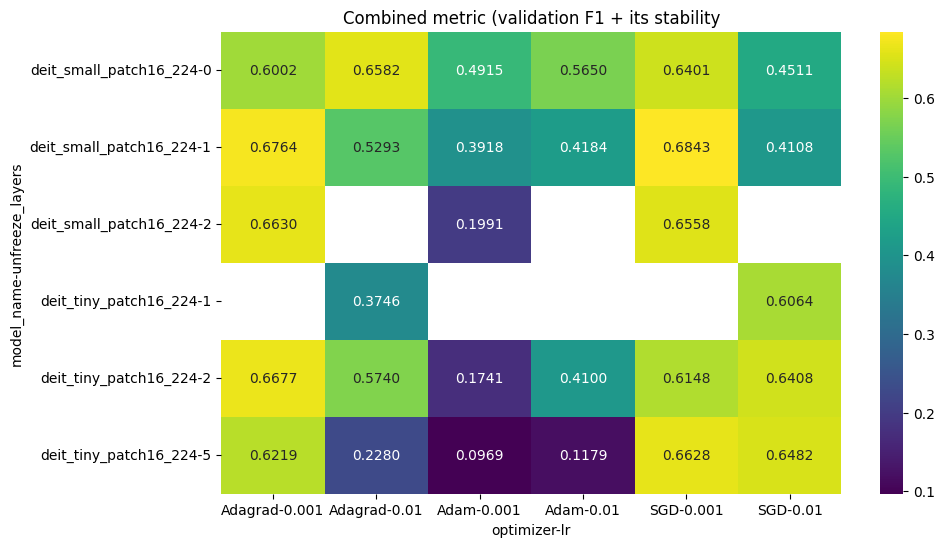

In [ ]:
# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = results.pivot_table(index=['model_name', 'unfreeze_layers'], columns=['optimizer', 'lr'], values='combined_metric')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='viridis')
plt.title('Combined metric (validation F1 + its stability')
plt.show()

Let's start with the model that's the first candidate among the ones selected by my formula (with a limited capacity). It's at least within my own top-5. 

# Fine-tune pre-trained ViT: train candidate models

Modify the building-training function once again: increase the number of epochs, implement early stopping, return the trained model. 

In [ ]:
def train_custom_model(model_name, unfreeze_layers, optimizer_fn, lr, **kwargs):

  #load the pre-trained model:
  model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=True)

  # Get the number of transformer layers
  num_transformer_layers = len(model.blocks)

  # Freeze all layers except the specified number of unfrozen layers
  for i in range(num_transformer_layers - unfreeze_layers):
      for param in model.blocks[i].parameters():
          param.requires_grad = False

  #adjust the head
  num_classes = 1
  in_features = model.head.in_features

  model.head = nn.Sequential(
      nn.BatchNorm1d(num_features=in_features), #include batch normalization for efficiency
      nn.ReLU(),
      nn.Linear(in_features, num_classes)
  )

  model = model.to(device)

  #create a weight tensor for the positive (minor) class
  pos_weight = torch.FloatTensor([imbalance_ratio]).to(device)

  #define the loss function
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device) #this one includes Sigmoid 
  #it's advised by Torch to use this instead of nn.Sigmoid in the net and BCELoss here. More stable.

  #define your optimizer
  optimizer = optimizer_fn(model.parameters(), lr=lr, **kwargs)

  # Define the learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

  # Early stopping parameters
  early_stopping_patience = 5 #was 10 for all the trials  except of the final-final model training
  best_val_loss = float('inf')
  epochs_without_improvement = 0

  num_epochs = 100
  for epoch in range(num_epochs):
      # Training
      train_loss = 0.0
      train_correct = 0
      train_total = 0
      train_f1_total = 0
      model.train()
      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels.float())
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          outputs = torch.sigmoid(outputs)  # apply sigmoid to get probabilities
          preds = (outputs.squeeze() >= 0.5).float()  
          train_correct += torch.sum(preds == labels.data)
          train_total += labels.size(0)
          train_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='macro') * labels.size(0)

      train_loss = train_loss / len(train_loader.dataset)
      train_acc = train_correct.item() / train_total
      train_f1 = train_f1_total / train_total

      # Validation
      val_loss = 0.0
      val_correct = 0
      val_total = 0
      val_f1_total = 0
      model.eval()
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs.squeeze(), labels.float())
              val_loss += loss.item()
              outputs = torch.sigmoid(outputs)
              preds = (outputs.squeeze() >= 0.5).float()
              val_correct += torch.sum(preds == labels.data)  
              val_total += labels.size(0)
              val_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='macro') * labels.size(0)

      val_loss = val_loss / len(val_loader.dataset)
      val_acc = val_correct.item() / val_total
      val_f1 = val_f1_total / val_total

      scheduler.step(val_loss)

      print(f'Epoch [{epoch+1}/{num_epochs}],\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, \
      Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

      # Check for early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_without_improvement = 0
      else:
          epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
          print("Early stopping triggered, stopping at epoch", epoch)
          break
  return model

In [ ]:
trained_model = train_custom_model('deit_small_patch16_224', 1, optim.SGD, 0.001)
torch.save(trained_model.state_dict(), '../crime_small_1_001_SGD.pth')

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/100],
Train Loss: 0.0334, Train Acc: 0.4950,       Train F1: 0.4532, Val Loss: 0.0333, Val Acc: 0.4900, Val F1: 0.4575
Epoch [2/100],
Train Loss: 0.0329, Train Acc: 0.5094,       Train F1: 0.4745, Val Loss: 0.0331, Val Acc: 0.5433, Val F1: 0.4929
Epoch [3/100],
Train Loss: 0.0327, Train Acc: 0.5309,       Train F1: 0.4877, Val Loss: 0.0329, Val Acc: 0.5315, Val F1: 0.4888
Epoch [4/100],
Train Loss: 0.0326, Train Acc: 0.5326,       Train F1: 0.4910, Val Loss: 0.0323, Val Acc: 0.5627, Val F1: 0.5143
Epoch [5/100],
Train Loss: 0.0324, Train Acc: 0.5440,       Train F1: 0.5034, Val Loss: 0.0327, Val Acc: 0.5662, Val F1: 0.5126
Epoch [6/100],
Train Loss: 0.0323, Train Acc: 0.5560,       Train F1: 0.5123, Val Loss: 0.0322, Val Acc: 0.6050, Val F1: 0.5376
Epoch [7/100],
Train Loss: 0.0322, Train Acc: 0.5750,       Train F1: 0.5238, Val Loss: 0.0324, Val Acc: 0.5482, Val F1: 0.5008
Epoch [8/100],
Train Loss: 0.0321, Train Acc: 0.5667,       Train F1: 0.5229, Val Loss: 0.0326, Val Acc:

Because I don't trust my own metric (knowing it's derived from SD and knowing the limitations of SD for my goals), I also train a model that I've chosen manually. This one is also withing the top-5 according to my formula, by the way. Let's see if it performs better. 

In [ ]:
trained_model = train_custom_model('deit_tiny_patch16_224', 5, optim.SGD, 0.001)
torch.save(trained_model.state_dict(), '../crime_tiny_5_001_SGD.pth')

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth
100%|██████████| 21.9M/21.9M [00:00<00:00, 159MB/s]


Epoch [1/100],
Train Loss: 0.0327, Train Acc: 0.4863,       Train F1: 0.4593, Val Loss: 0.0333, Val Acc: 0.5385, Val F1: 0.4956
Epoch [2/100],
Train Loss: 0.0323, Train Acc: 0.5497,       Train F1: 0.5027, Val Loss: 0.0331, Val Acc: 0.5835, Val F1: 0.5278
Epoch [3/100],
Train Loss: 0.0322, Train Acc: 0.5710,       Train F1: 0.5166, Val Loss: 0.0324, Val Acc: 0.5842, Val F1: 0.5356
Epoch [4/100],
Train Loss: 0.0318, Train Acc: 0.5750,       Train F1: 0.5269, Val Loss: 0.0325, Val Acc: 0.6015, Val F1: 0.5500
Epoch [5/100],
Train Loss: 0.0315, Train Acc: 0.6009,       Train F1: 0.5487, Val Loss: 0.0323, Val Acc: 0.6043, Val F1: 0.5514
Epoch [6/100],
Train Loss: 0.0314, Train Acc: 0.5970,       Train F1: 0.5429, Val Loss: 0.0321, Val Acc: 0.5925, Val F1: 0.5444
Epoch [7/100],
Train Loss: 0.0312, Train Acc: 0.6010,       Train F1: 0.5504, Val Loss: 0.0321, Val Acc: 0.6209, Val F1: 0.5644
Epoch [8/100],
Train Loss: 0.0312, Train Acc: 0.6019,       Train F1: 0.5490, Val Loss: 0.0319, Val Acc:

Not the performance we are hoping for. Let's try with the second choice of the formula, and then with my own second choice.

In [ ]:
trained_model = train_custom_model('deit_small_patch16_224', 1, optim.Adagrad, 0.001)
torch.save(trained_model.state_dict(), '../crime_small_1_001_Adagrad.pth')

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth" to /root/.cache/torch/hub/checkpoints/deit_small_patch16_224-cd65a155.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 151MB/s]


Epoch [1/100],
Train Loss: 0.0323, Train Acc: 0.5593,       Train F1: 0.5054, Val Loss: 0.0334, Val Acc: 0.6230, Val F1: 0.5375
Epoch [2/100],
Train Loss: 0.0313, Train Acc: 0.6075,       Train F1: 0.5525, Val Loss: 0.0325, Val Acc: 0.6279, Val F1: 0.5530
Epoch [3/100],
Train Loss: 0.0311, Train Acc: 0.6240,       Train F1: 0.5585, Val Loss: 0.0321, Val Acc: 0.6133, Val F1: 0.5516
Epoch [4/100],
Train Loss: 0.0308, Train Acc: 0.6310,       Train F1: 0.5681, Val Loss: 0.0320, Val Acc: 0.5981, Val F1: 0.5417
Epoch [5/100],
Train Loss: 0.0304, Train Acc: 0.6368,       Train F1: 0.5760, Val Loss: 0.0323, Val Acc: 0.6445, Val F1: 0.5677
Epoch [6/100],
Train Loss: 0.0304, Train Acc: 0.6501,       Train F1: 0.5869, Val Loss: 0.0315, Val Acc: 0.6320, Val F1: 0.5728
Epoch [7/100],
Train Loss: 0.0300, Train Acc: 0.6512,       Train F1: 0.5900, Val Loss: 0.0318, Val Acc: 0.6195, Val F1: 0.5619
Epoch [8/100],
Train Loss: 0.0298, Train Acc: 0.6530,       Train F1: 0.5896, Val Loss: 0.0322, Val Acc:

And now my second choice, but we make the learning rate a bit smaller, because it oscillated.

In [ ]:
trained_model = train_custom_model('deit_tiny_patch16_224', 2, optim.SGD, 0.007)
torch.save(trained_model.state_dict(), '../crime_tiny_2_007_SGD.pth')

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/100],
Train Loss: 0.0325, Train Acc: 0.5418,       Train F1: 0.4942, Val Loss: 0.0334, Val Acc: 0.6424, Val F1: 0.5292
Epoch [2/100],
Train Loss: 0.0319, Train Acc: 0.6010,       Train F1: 0.5382, Val Loss: 0.0326, Val Acc: 0.5475, Val F1: 0.5185
Epoch [3/100],
Train Loss: 0.0314, Train Acc: 0.6000,       Train F1: 0.5495, Val Loss: 0.0330, Val Acc: 0.5877, Val F1: 0.5216
Epoch [4/100],
Train Loss: 0.0314, Train Acc: 0.6016,       Train F1: 0.5467, Val Loss: 0.0325, Val Acc: 0.6279, Val F1: 0.5567
Epoch [5/100],
Train Loss: 0.0314, Train Acc: 0.5991,       Train F1: 0.5426, Val Loss: 0.0326, Val Acc: 0.6417, Val F1: 0.5418
Epoch [6/100],
Train Loss: 0.0310, Train Acc: 0.6175,       Train F1: 0.5591, Val Loss: 0.0326, Val Acc: 0.6556, Val F1: 0.5642
Epoch [7/100],
Train Loss: 0.0306, Train Acc: 0.6283,       Train F1: 0.5709, Val Loss: 0.0325, Val Acc: 0.6126, Val F1: 0.5509
Epoch [8/100],
Train Loss: 0.0307, Train Acc: 0.6268,       Train F1: 0.5695, Val Loss: 0.0325, Val Acc:

In [ ]:
trained_model = train_custom_model('deit_tiny_patch16_224', 5, optim.SGD, 0.01)
torch.save(trained_model.state_dict(), '../crime_tiny_5_01_SGD.pth')

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch [1/100],
Train Loss: 0.0324, Train Acc: 0.5439,       Train F1: 0.4897, Val Loss: 0.0329, Val Acc: 0.6008, Val F1: 0.5397
Epoch [2/100],
Train Loss: 0.0314, Train Acc: 0.5936,       Train F1: 0.5341, Val Loss: 0.0328, Val Acc: 0.6584, Val F1: 0.5661
Epoch [3/100],
Train Loss: 0.0311, Train Acc: 0.6159,       Train F1: 0.5573, Val Loss: 0.0321, Val Acc: 0.4844, Val F1: 0.4707
Epoch [4/100],
Train Loss: 0.0308, Train Acc: 0.6154,       Train F1: 0.5591, Val Loss: 0.0323, Val Acc: 0.6570, Val F1: 0.5864
Epoch [5/100],
Train Loss: 0.0303, Train Acc: 0.6337,       Train F1: 0.5747, Val Loss: 0.0311, Val Acc: 0.6958, Val F1: 0.6055
Epoch [6/100],
Train Loss: 0.0302, Train Acc: 0.6430,       Train F1: 0.5814, Val Loss: 0.0320, Val Acc: 0.6604, Val F1: 0.5768
Epoch [7/100],
Train Loss: 0.0299, Train Acc: 0.6411,       Train F1: 0.5826, Val Loss: 0.0316, Val Acc: 0.5766, Val F1: 0.5514
Epoch [8/100],
Train Loss: 0.0296, Train Acc: 0.6451,       Train F1: 0.5898, Val Loss: 0.0310, Val Acc:

Seems like the first two choices produce the best results. Let's take the hyperparameters of the second model, but take the more complex Deit Small instead of Deit Tiny, and apply regularization to this more complex model. Let's also store the indices for the test set so that we could proceed to our explainability pipeline later with the data that the model has certainly never seen before. 

In [ ]:
# Determine the size of the train/validation split
train_size = int(len(custom_dataset) * 0.7) #we used 0.25 for hyperparameter selection here
val_size = int(len(custom_dataset) * 0.15)
test_size = len(custom_dataset) - train_size - val_size

# Randomly split the dataset into train and validation sets
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Save the indices of the datasets
torch.save(train_dataset.indices, '../train_indices_1.pt')
torch.save(val_dataset.indices, '../val_indices_1.pt')
torch.save(test_dataset.indices, '../test_indices_1.pt')

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
trained_model = train_custom_model('deit_small_patch16_224', 5, optim.SGD, 0.001, weight_decay=1e-4)
torch.save(trained_model.state_dict(), '../crime_small_5_001_SGD.pth')
#the last run was on the khna89, so the files should be taken from there

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth" to /root/.cache/torch/hub/checkpoints/deit_small_patch16_224-cd65a155.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 90.6MB/s]


Epoch [1/100],
Train Loss: 0.0331, Train Acc: 0.5023,       Train F1: 0.4627, Val Loss: 0.0333, Val Acc: 0.4879, Val F1: 0.4544
Epoch [2/100],
Train Loss: 0.0327, Train Acc: 0.5228,       Train F1: 0.4843, Val Loss: 0.0329, Val Acc: 0.5911, Val F1: 0.5138
Epoch [3/100],
Train Loss: 0.0324, Train Acc: 0.5534,       Train F1: 0.5063, Val Loss: 0.0330, Val Acc: 0.5717, Val F1: 0.5031
Epoch [4/100],
Train Loss: 0.0322, Train Acc: 0.5747,       Train F1: 0.5203, Val Loss: 0.0324, Val Acc: 0.5586, Val F1: 0.5183
Epoch [5/100],
Train Loss: 0.0319, Train Acc: 0.5764,       Train F1: 0.5295, Val Loss: 0.0323, Val Acc: 0.5925, Val F1: 0.5430
Epoch [6/100],
Train Loss: 0.0316, Train Acc: 0.5970,       Train F1: 0.5460, Val Loss: 0.0324, Val Acc: 0.6029, Val F1: 0.5397
Epoch [7/100],
Train Loss: 0.0316, Train Acc: 0.5972,       Train F1: 0.5450, Val Loss: 0.0320, Val Acc: 0.5863, Val F1: 0.5394
Epoch [8/100],
Train Loss: 0.0315, Train Acc: 0.5979,       Train F1: 0.5482, Val Loss: 0.0316, Val Acc:

# Evaluation

In [9]:
# Load the indices (when resuming)
train_indices = torch.load('../train_indices_1.pt')
val_indices = torch.load('../val_indices_1.pt')
test_indices = torch.load('../test_indices_1.pt')

# Create the datasets using the loaded indices
train_dataset = Subset(custom_dataset, train_indices)
val_dataset = Subset(custom_dataset, val_indices)
test_dataset = Subset(custom_dataset, test_indices)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
#re-build the model as initially and load the fine-tuned weights
model = torch.hub.load('facebookresearch/deit:main', 'deit_small_patch16_224', pretrained=False)

num_transformer_layers = len(model.blocks)

for i in range(num_transformer_layers - 5):
    for param in model.blocks[i].parameters():
        param.requires_grad = False

num_classes = 1
in_features = model.head.in_features

model.head = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features), 
    nn.ReLU(),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)
model.load_state_dict(torch.load('../crime_small_5_001_SGD.pth'))

model.eval()

pos_weight = torch.FloatTensor([imbalance_ratio]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device) #this one includes Sigmoid 

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Performance on the test set:

In [ ]:
test_loss, test_correct, test_total, test_f1_total = 0.0, 0, 0, 0

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels.float())
    test_loss += loss.item()
    outputs = torch.sigmoid(outputs)
    preds = (outputs.squeeze() >= 0.5).float()
    test_correct += torch.sum(preds == labels.data)  
    test_total += labels.size(0)
    test_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='macro') * labels.size(0)

test_loss /= test_total
test_acc = test_correct.item() / test_total
test_f1 = test_f1_total / test_total

print('Test performance of Deit Small with 5 unfrozen layers, SGD as optimizer, lr=0.01')
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}')

Test performance of Deit Small with 5 unfrozen layers, SGD as optimizer, lr=0.01
Test Loss: 0.0313, Test Acc: 0.6381, Test F1: 0.5700


To see performance manually on concrete examples:

In [49]:
%matplotlib inline

def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225])[:, None, None] + torch.tensor([0.485, 0.456, 0.406])[:, None, None]  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(30, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Class 1:
Pred: 1, Label: 1          Pred: 0, Label: 1          Pred: 1, Label: 1          Pred: 1, Label: 1          Pred: 1, Label: 1          Pred: 1, Label: 1          

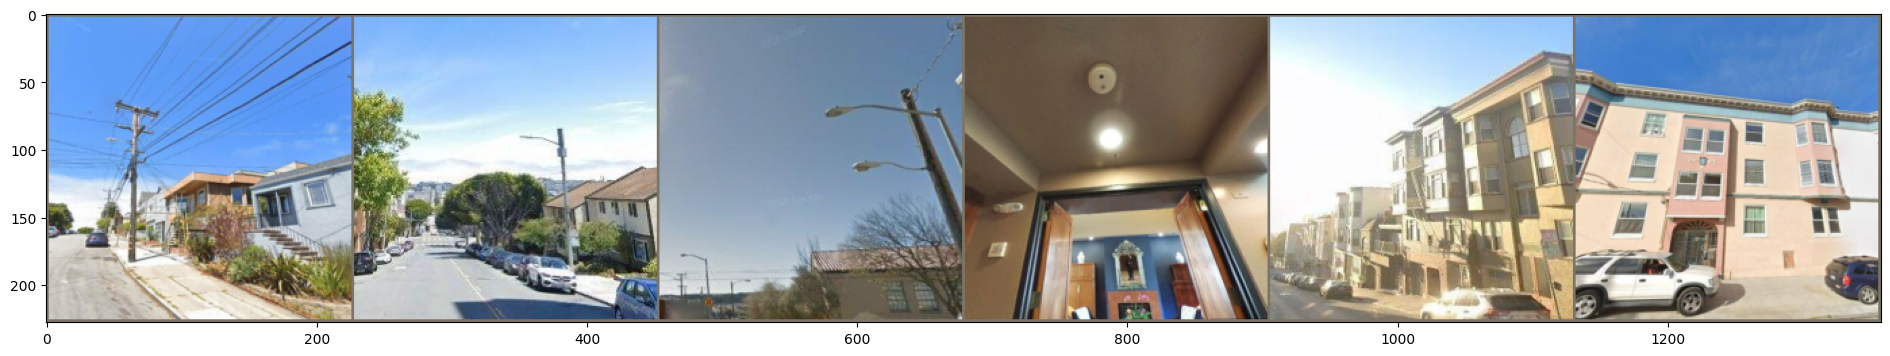

Class 0:
Pred: 0, Lab: 0 | Pred: 1, Lab: 0 | Pred: 1, Lab: 0 | Pred: 1, Lab: 0 | Pred: 0, Lab: 0 | Pred: 0, Lab: 0 | Pred: 0, Lab: 0 | Pred: 1, Lab: 0 | Pred: 0, Lab: 0 | 

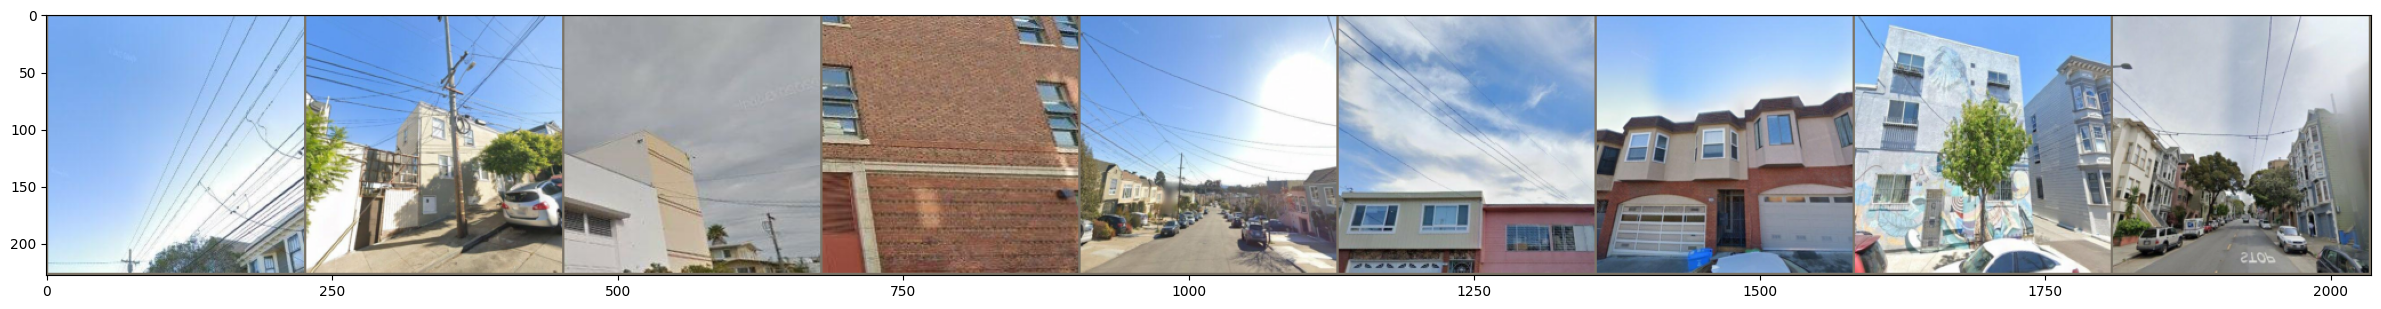

Test Acc: 0.6667, Test F1: 0.6667


In [57]:
class_0_images = []
class_1_images = []
class_0_pred_label = []
class_1_pred_label = []

test_correct, test_total, test_f1_total = 0, 0, 0
model.eval()
with torch.no_grad():
    for batch_index, (inputs, labels) in enumerate(test_loader):
        if batch_index == 0:  # Only take the first batch
            inputs, labels = inputs[:15].to(device), labels[:15].to(device)  # Select the first 15 examples
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            outputs = torch.sigmoid(outputs)
            preds = (outputs.squeeze() >= 0.5).float()

            test_correct += torch.sum(preds == labels.data)  
            test_total += labels.size(0)
            test_f1_total += f1_score(labels.cpu().detach(), preds.cpu().detach(), average='macro') * labels.size(0)

            inputs_cpu = inputs.cpu()
            preds_cpu = preds.cpu()
            labels_cpu = labels.cpu()

            for img, pred, label in zip(inputs_cpu, preds, labels):
                if label == 1:
                    class_1_images.append(img)
                    class_1_pred_label.append((pred, label))
                else:
                    class_0_images.append(img)
                    class_0_pred_label.append((pred, label))
        else:
            break

# Display the images, predictions, and labels for class 1
print("Class 1:")
for pred, label in class_1_pred_label:
    print(f"Pred: {int(pred.item())}, Label: {label.item()}", end="          ")
imshow(torchvision.utils.make_grid(class_1_images, nrow = len(class_1_images)))

# Display the images, predictions, and labels for class 0
print("Class 0:")
for pred, label in class_0_pred_label:
    print(f"Pred: {int(pred.item())}, Lab: {label.item()}", end=" | ")

imshow(torchvision.utils.make_grid(class_0_images, nrow = len(class_0_images)))

test_acc = test_correct.item() / test_total
test_f1 = test_f1_total / test_total

print(f'Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}')

# Following the Gildenblat's post on heat maps for vision transformers

Adapted from Gildenblat, J. (2020). Exploring Explainability for Vision Transformers. https://jacobgil.github.io/deeplearning/vision-transformer-explainability

In [11]:
os.chdir(os.pardir)
print(os.getcwd())
!ls

/content/drive/MyDrive/for thesis
crime_small_1_001_Adagrad.pth  green_data_coords.csv  test_indices_1.pt
crime_small_5_001_SGD.pth      labels_35_m.npz	      train_indices_1.pt
crime_tiny_2_007_SGD.pth       nl_svi		      val_indices_1.pt
crime_tiny_5_001_SGD.pth       Only_San_Fran	      vit-explain
crime_tiny_5_01_SGD.pth        results.csv


In [15]:
!git clone https://github.com/jacobgil/vit-explain

fatal: destination path 'vit-explain' already exists and is not an empty directory.


In [12]:
os.chdir('./vit-explain')
!ls

examples  __pycache__  vit_explain.py	    vit_rollout.py
LICENSE   Readme.md    vit_grad_rollout.py


Below is the function of Gildenblat's, modified to account for my binary classification fine-tuned model and from running from within the notebook.

In [12]:
os.chdir('../vit-explain')
from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

In [13]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def show_att_map(image_t, target, head_fusion='max', discard_ratio=0.9, category_index = None):

    input_tensor = image_t.unsqueeze(0)
    input_tensor = input_tensor.to(device)

    if category_index is None:
        print("Doing Attention Rollout")
        output = model(input_tensor) 
        preds = torch.round(torch.sigmoid(output)) 
        print("Pred:", preds.item())
        print("Label:", target.item())
        attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
            discard_ratio=discard_ratio)
        mask = attention_rollout(input_tensor)

    else:
        print("Doing Gradient Attention Rollout")
        grad_rollout = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
        mask = grad_rollout(input_tensor, category_index)


    np_img = image_t.cpu().numpy() 
    np_img = np.transpose(np_img, (1, 2, 0)) 
    np_img = np_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) 
    np_img = (np_img * 255).astype(np.uint8)  
    np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR) 

    mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
    mask = show_mask_on_image(np_img, mask)
    cv2_imshow(np_img)
    cv2_imshow(mask)

In [17]:
os.chdir("../Only_San_Fran")
def get_extreme_indices(num_samples=300):
    extreme_indices = []
    logits = []

    with torch.no_grad():
        for batch_index, (inputs, labels) in enumerate(test_loader):
            if (batch_index+1) * test_loader.batch_size < num_samples:  # Limit to num_samples samples
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predictions = torch.round(torch.sigmoid(outputs))
                predictions = predictions.view(-1)
                correct_predictions = (predictions == labels)
                correct_logits = outputs[correct_predictions].cpu().numpy()
                logits.extend(correct_logits)
                for i, is_correct in enumerate(correct_predictions):
                    if is_correct:
                        # Compute the index of the sample in the dataset
                        sample_index = batch_index * test_loader.batch_size + i
                        extreme_indices.append(sample_index)
            else:
                break

    # Sort the indices based on the most extreme logits
    sorted_indices = sorted(extreme_indices, key=lambda x: abs(logits[extreme_indices.index(x)]), reverse=True)
    return sorted_indices

model.eval()
indices = get_extreme_indices(300)


Doing Attention Rollout
Pred: 1.0
Label: 1


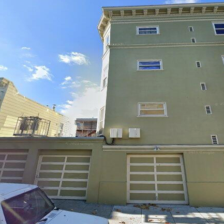

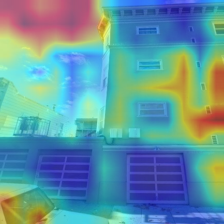

Doing Attention Rollout
Pred: 1.0
Label: 1


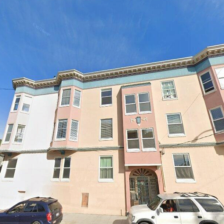

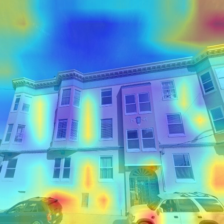

Doing Attention Rollout
Pred: 1.0
Label: 1


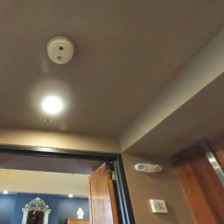

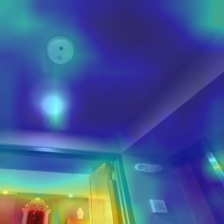

Doing Attention Rollout
Pred: 1.0
Label: 1


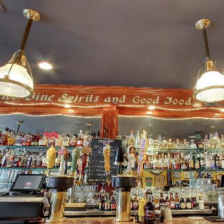

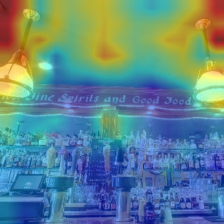

Doing Attention Rollout
Pred: 1.0
Label: 1


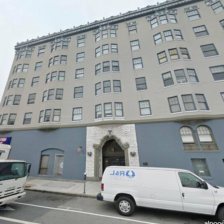

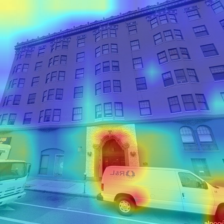

Doing Attention Rollout
Pred: 0.0
Label: 0


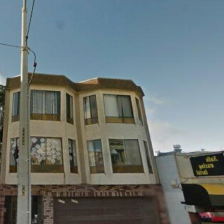

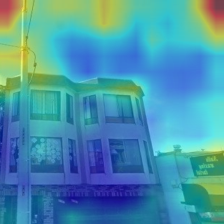

Doing Attention Rollout
Pred: 0.0
Label: 0


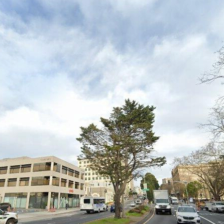

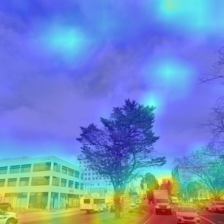

Doing Attention Rollout
Pred: 0.0
Label: 0


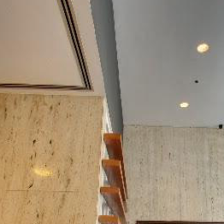

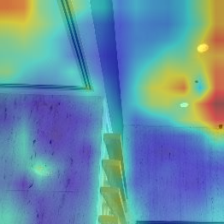

Doing Attention Rollout
Pred: 0.0
Label: 0


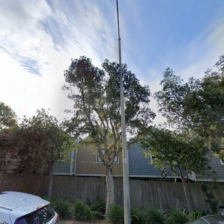

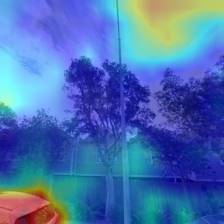

Doing Attention Rollout
Pred: 1.0
Label: 1


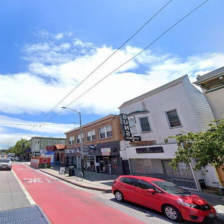

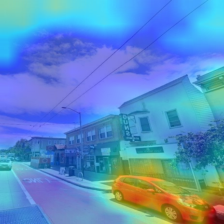

In [20]:
top_n = 10
for index in indices[:top_n]:
  image_t, target = test_dataset[index]
  show_att_map(image_t, target, head_fusion='max', discard_ratio=0.9, category_index = None)

In [21]:
print(indices)

[125, 12, 5, 167, 80, 95, 46, 250, 133, 205, 3, 179, 92, 64, 96, 109, 26, 71, 227, 113, 263, 220, 105, 245, 2, 20, 166, 76, 98, 145, 268, 237, 278, 97, 36, 1, 65, 277, 280, 175, 154, 139, 72, 196, 251, 271, 67, 192, 211, 276, 275, 107, 108, 112, 255, 21, 204, 43, 194, 210, 44, 37, 193, 212, 252, 24, 55, 50, 215, 173, 244, 103, 83, 38, 45, 34, 32, 236, 242, 235, 240, 59, 232, 243, 182, 136, 208, 91, 159, 87, 22, 143, 61, 15, 25, 142, 283, 134, 183, 151, 248, 239, 188, 35, 68, 264, 88, 120, 140, 119, 231, 33, 178, 187, 117, 221, 258, 267, 137, 130, 228, 58, 62, 122, 172, 47, 115, 265, 262, 135, 269, 40, 78, 60, 124, 254, 249, 0, 285, 197, 9, 116, 174, 81, 73, 191, 286, 90, 201, 152, 287, 229, 155, 57, 19, 70, 18, 168, 82, 202, 171, 16, 272, 146, 195, 99, 123, 149, 226, 30, 11, 207, 14, 198, 279, 162, 126, 141, 144, 49, 8, 42, 127, 39, 203, 224, 75]
